# Análisis de la siniestralidad en accidentes de automóviles en Canada

 <ul>
<li> Autores: Alberto Doncel Pedrosa y Pablo Bastida Escudero</li>
<li> Fecha: 16/12/2021</li>
<li> Email: pablo.bastida@cunef.edu y alberto.doncel@cunef.edu</li>
<li> Centro: CUNEF Universidad</li>    
</ul>

El objetivo general del presente proyecto es la creación de un modelo de Machine Learning para su posterior puesta en producción con el objetivo de predecir la probabilidad de fallecimiento ante un accidente de tráfico dado una serie de condicionantes o características. Esta predicción permite a la aseguradora calcular la posible provisión de fondos que está obligada a bloquear para hacer frente a las indemnizaciones por accidente.

Como base de entrenamiento de los modelos se utilizará un dataset de accidentes de tráfico de Canadá entre 1994 y 2014.

Metología:
<ul>
<li> Lectura de los datos</li>
<li> Análisis exploratorio de los datos y comprensión del conjunto de datos.</li>
<li> Selección de variables en base a criterios de optimización y de su análisis exploratorio.</li>
<li> Modelos predictivos y optimización de hiperparámetros</li>

Antes de comenzar el análisis, importamos las librerías:

Importación de librería que van a ser usadas durante el desarrollo del proyecto.

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn
from sklearn.impute import SimpleImputer
import category_encoders as ce
from category_encoders import TargetEncoder
import warnings
from sklearn.datasets import make_classification
from imblearn.under_sampling import NearMiss
warnings.filterwarnings("ignore")
from collections import Counter
from imblearn.over_sampling import SMOTE
from numpy import where
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display, Image

# Diccionario de Datos

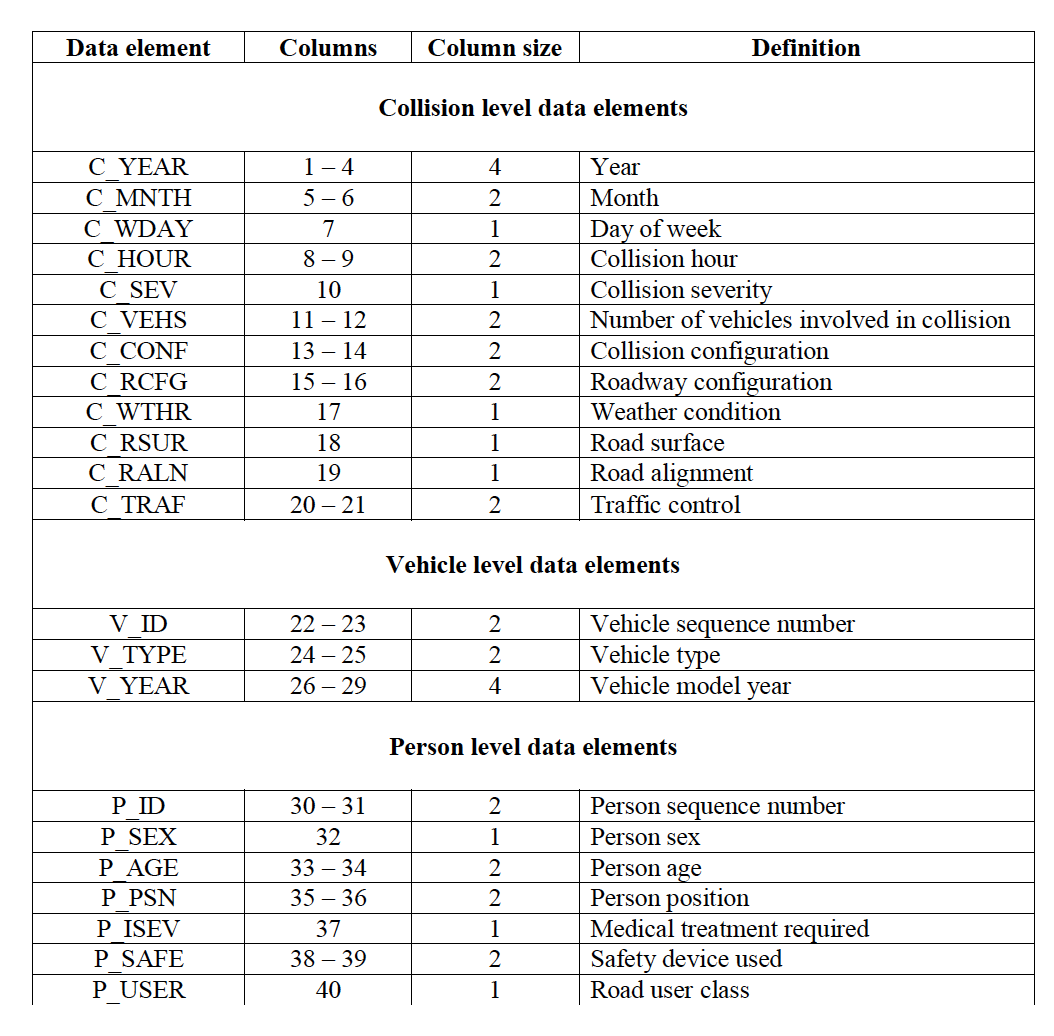

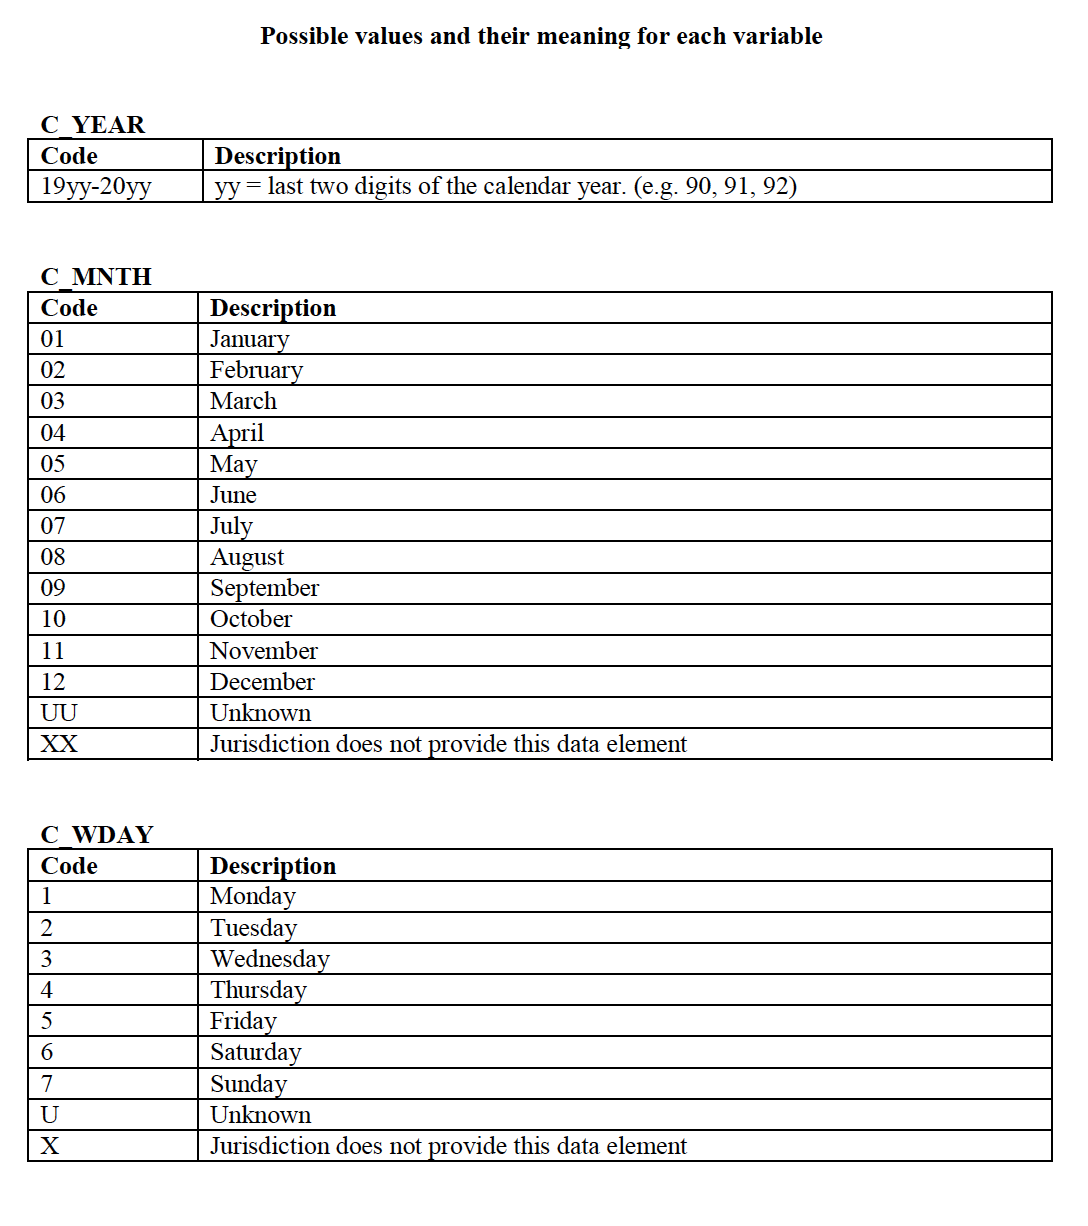

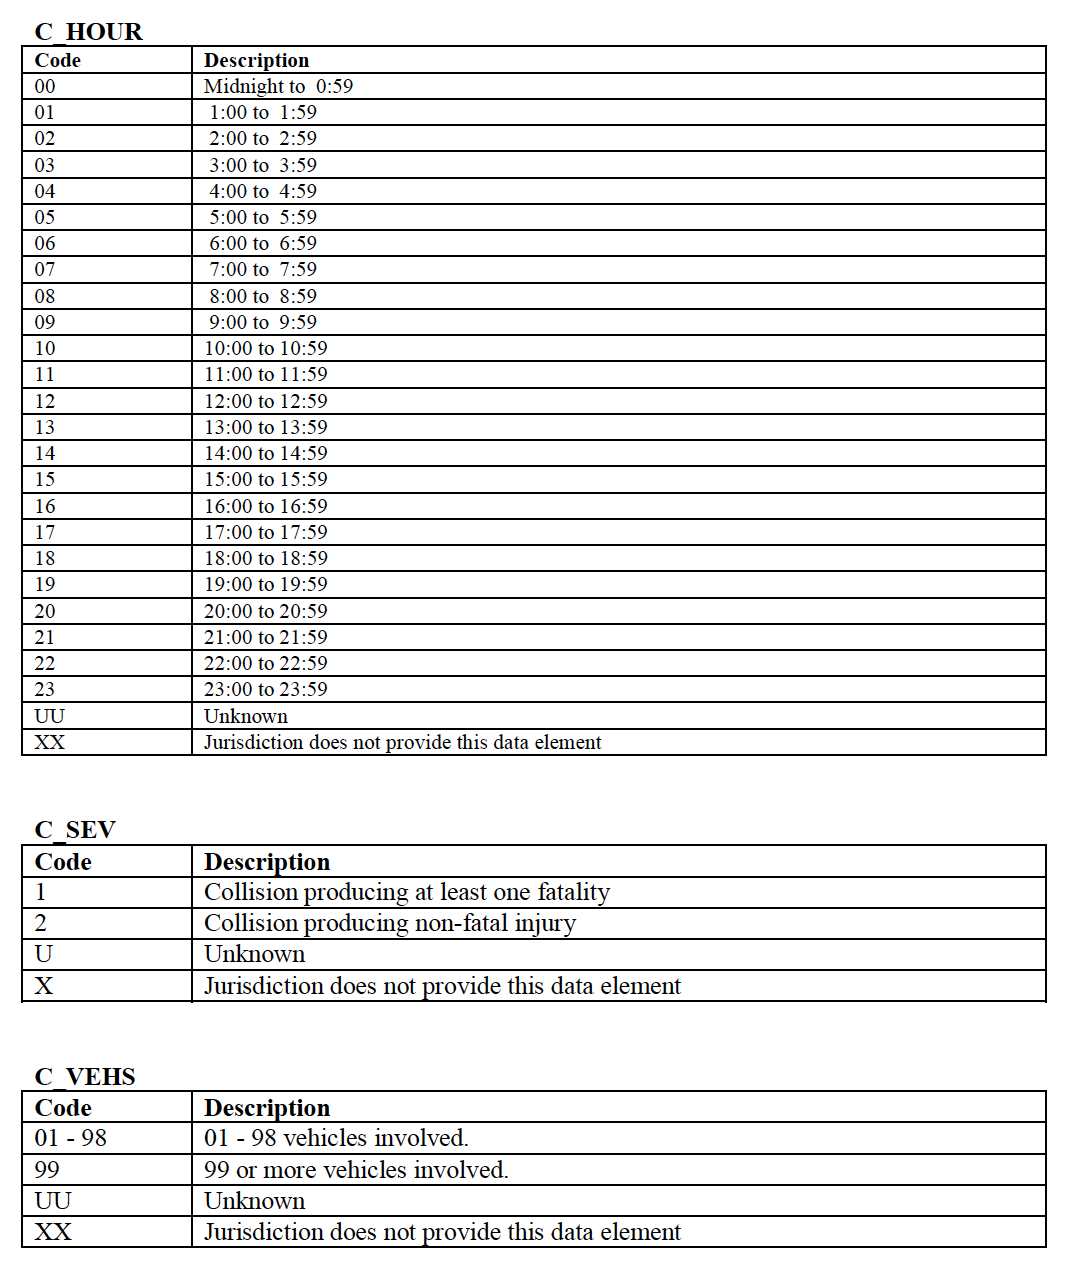

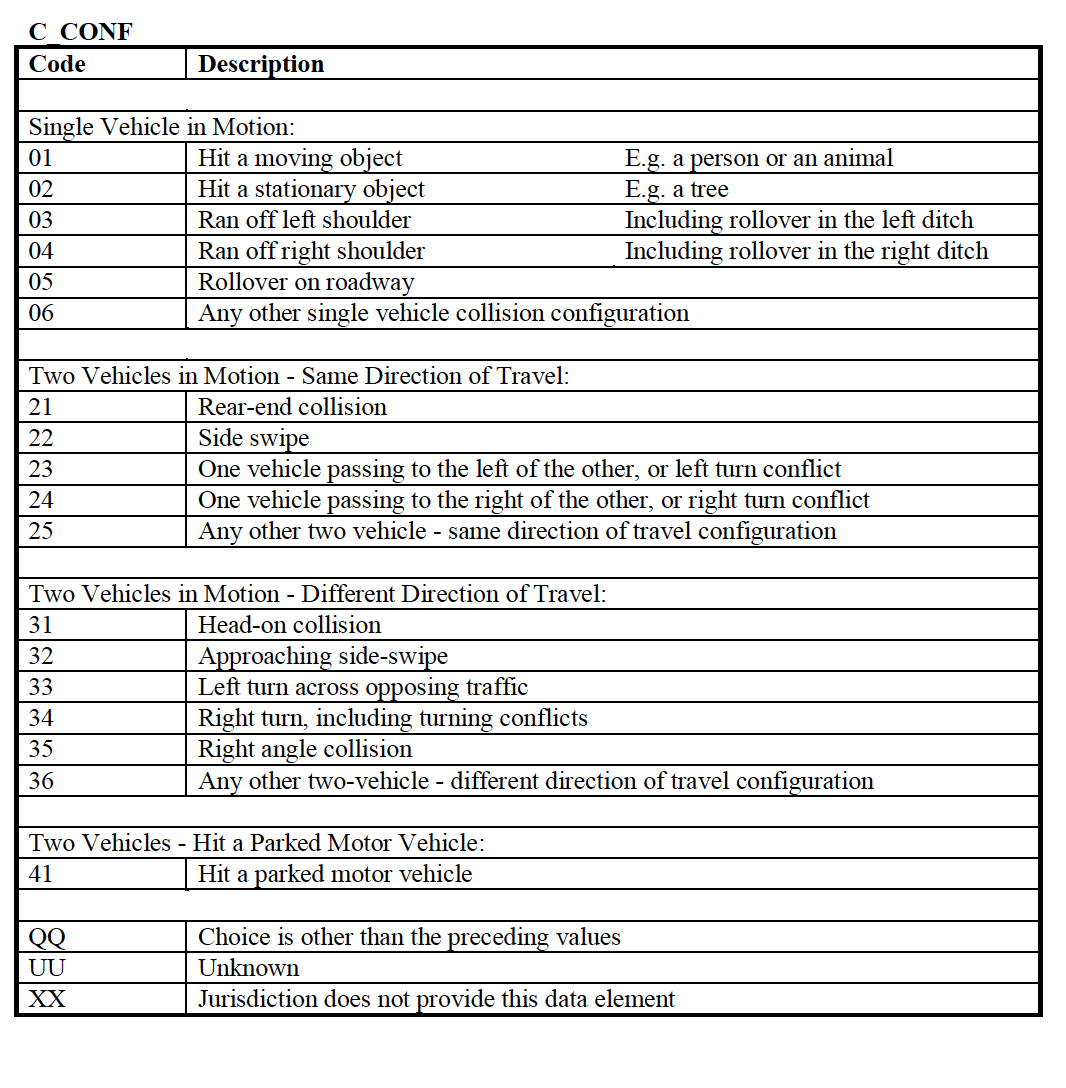

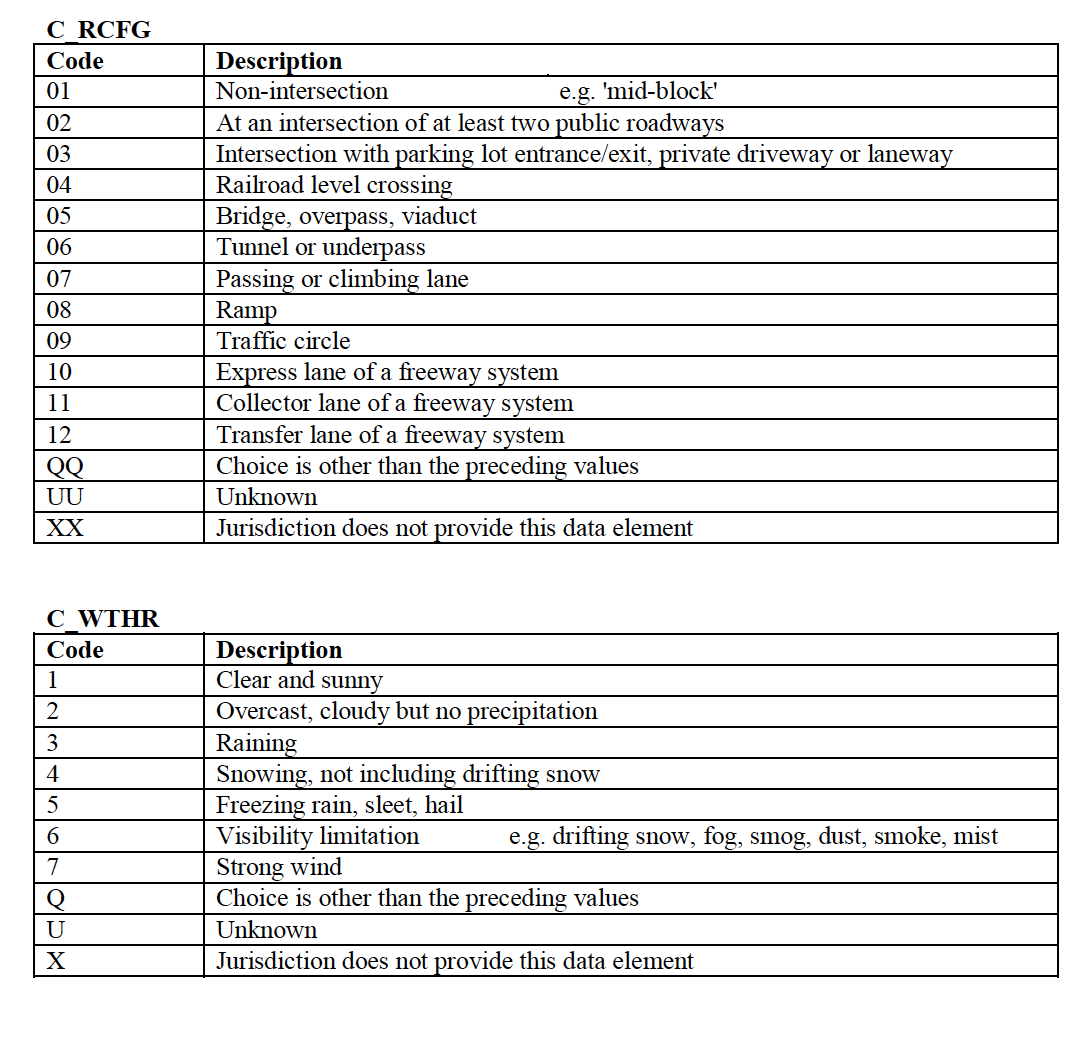

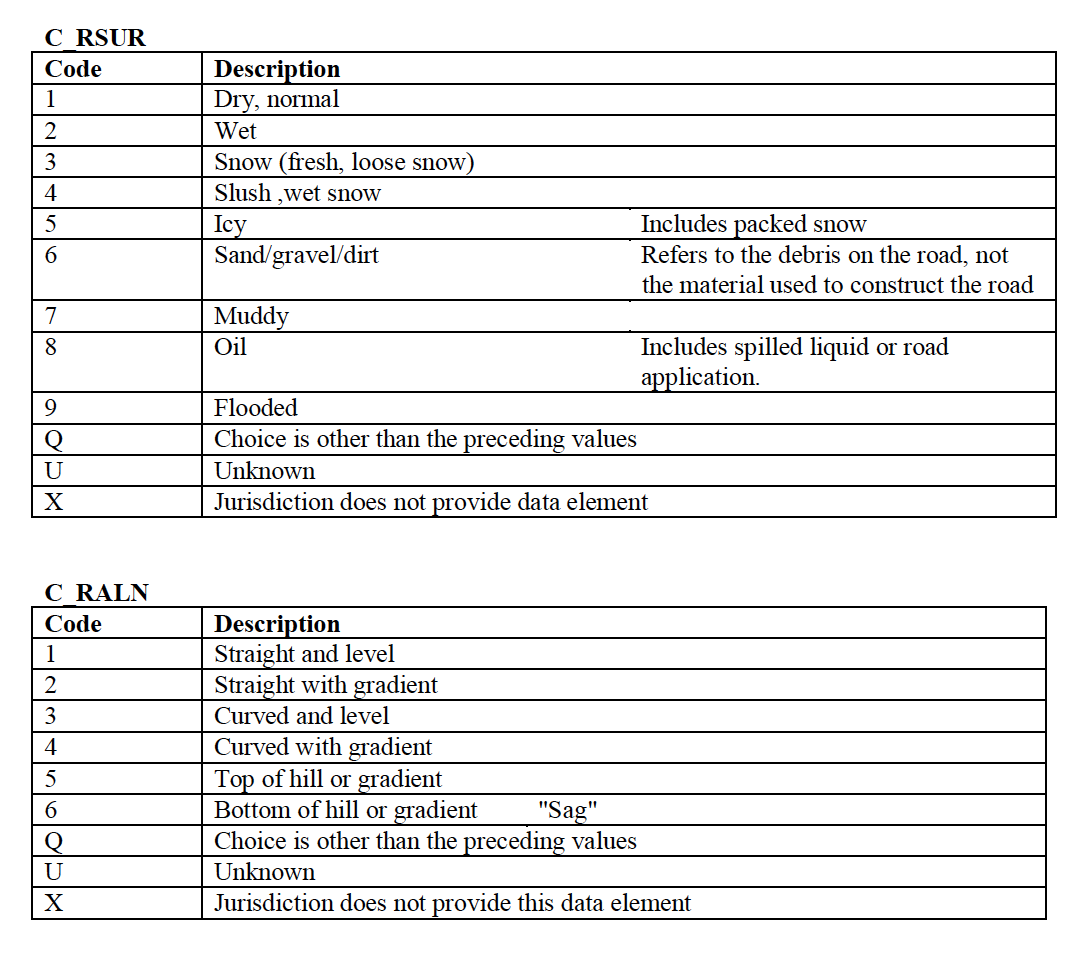

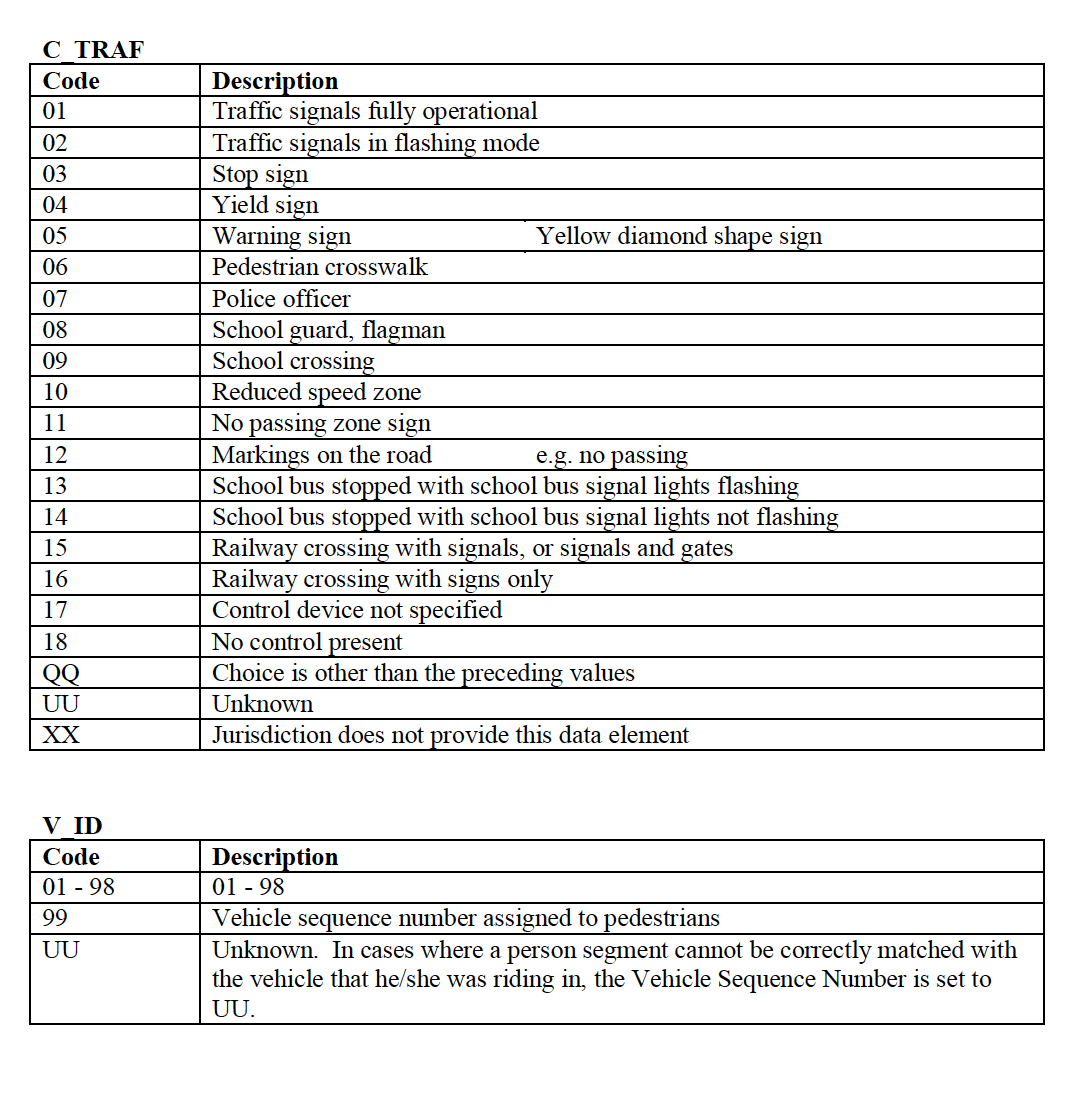

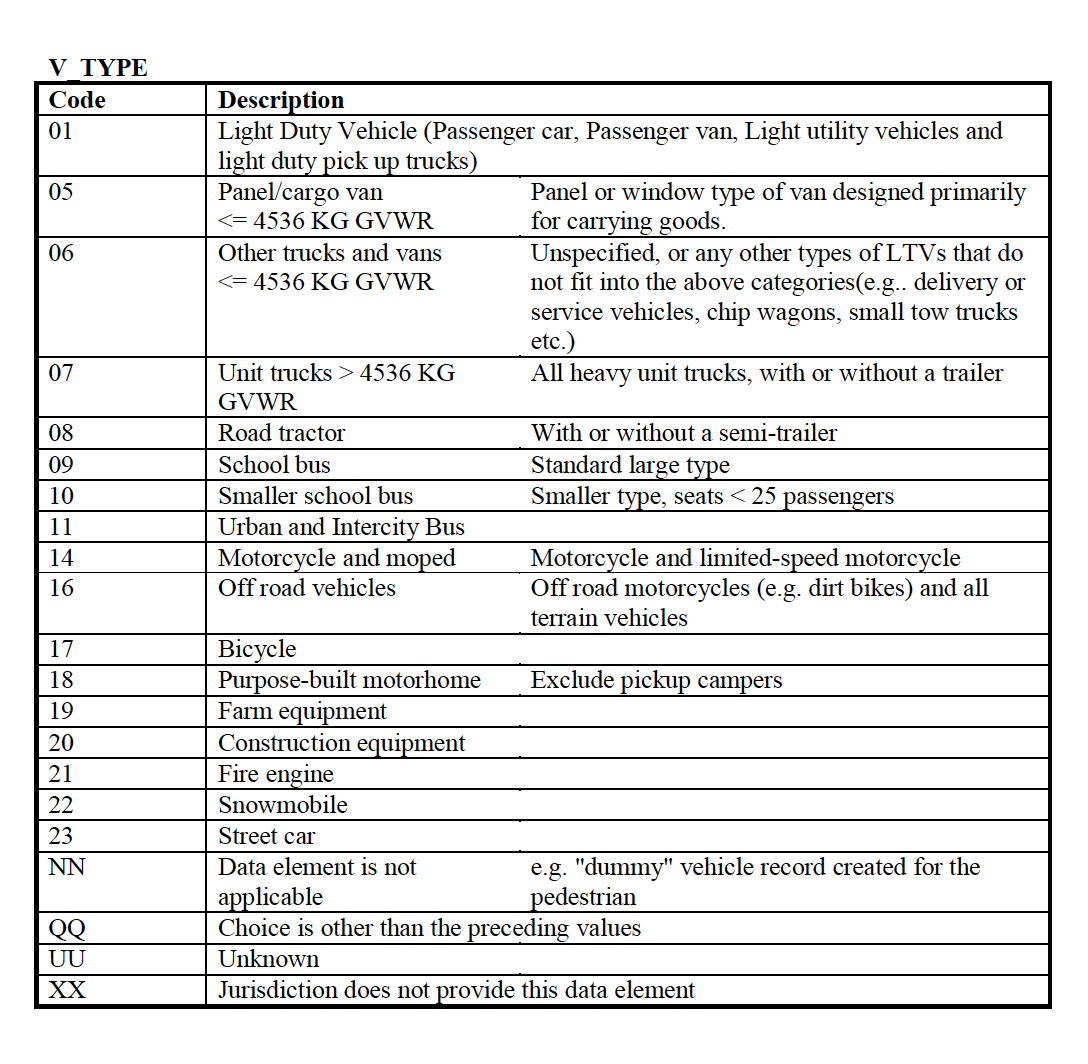

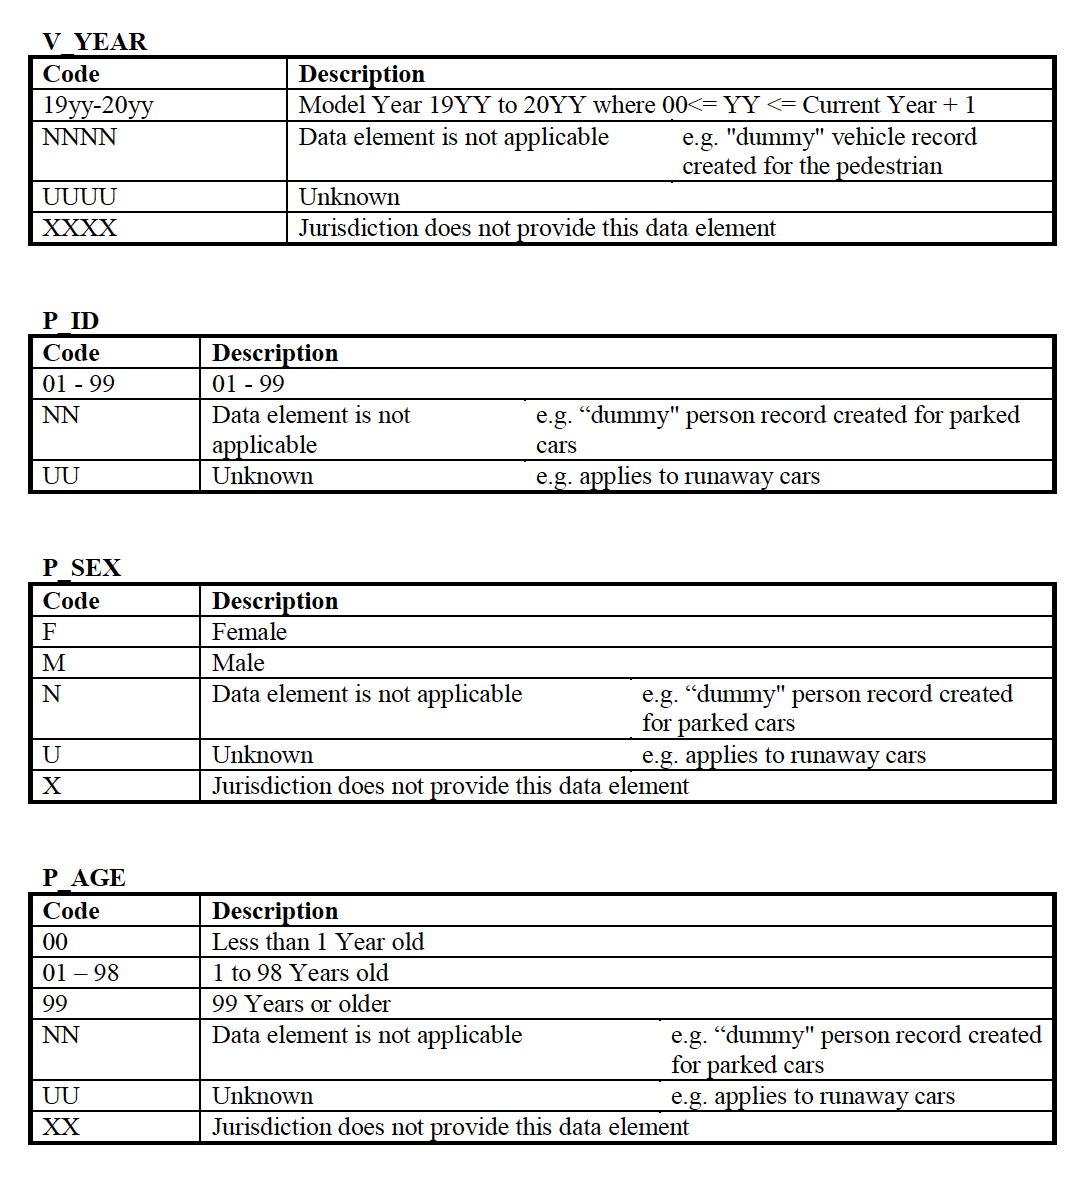

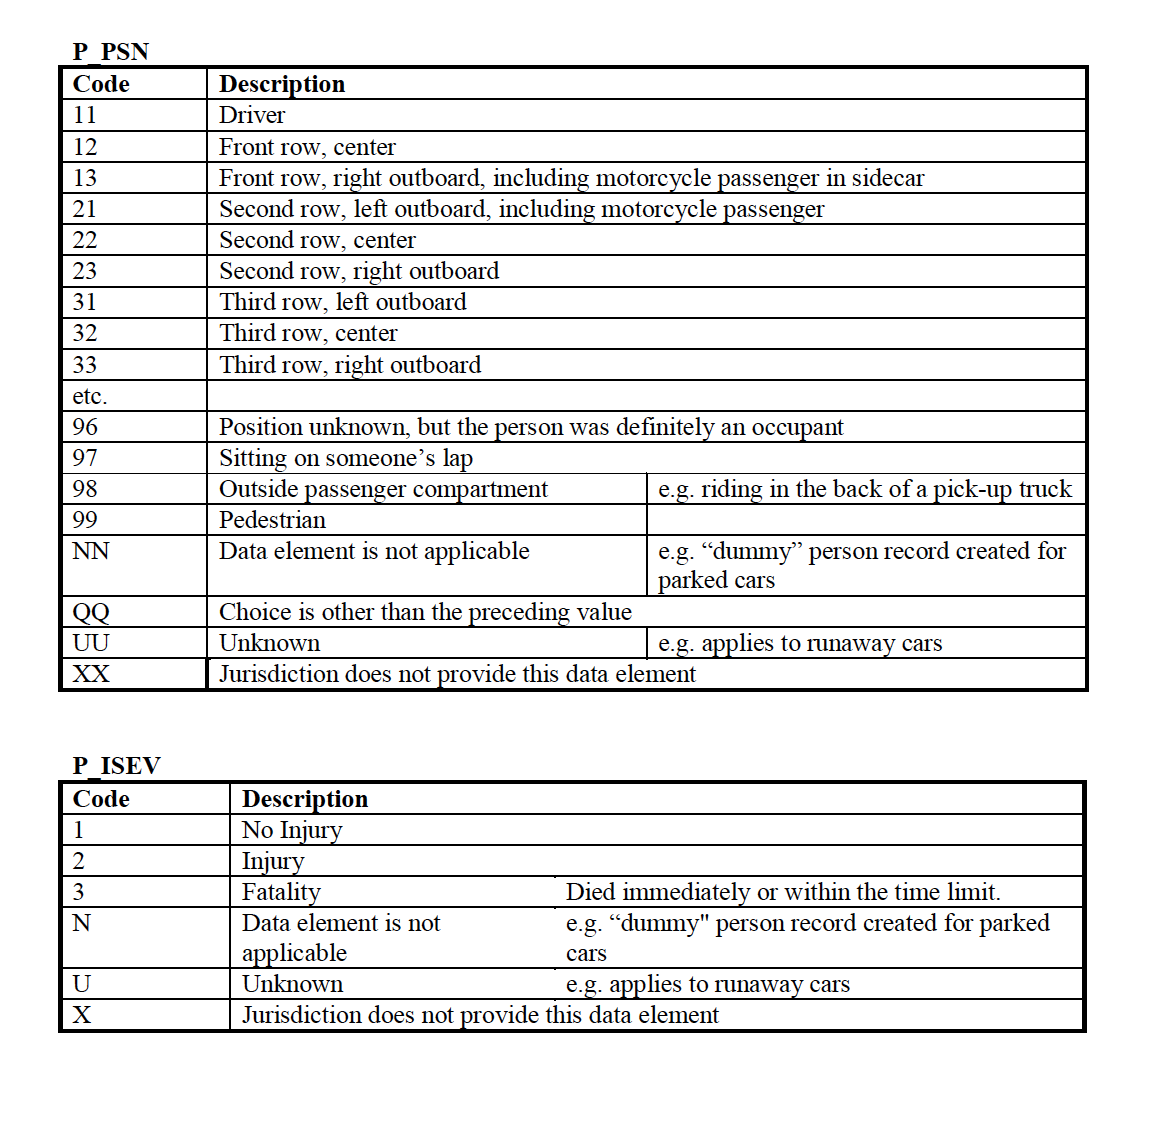

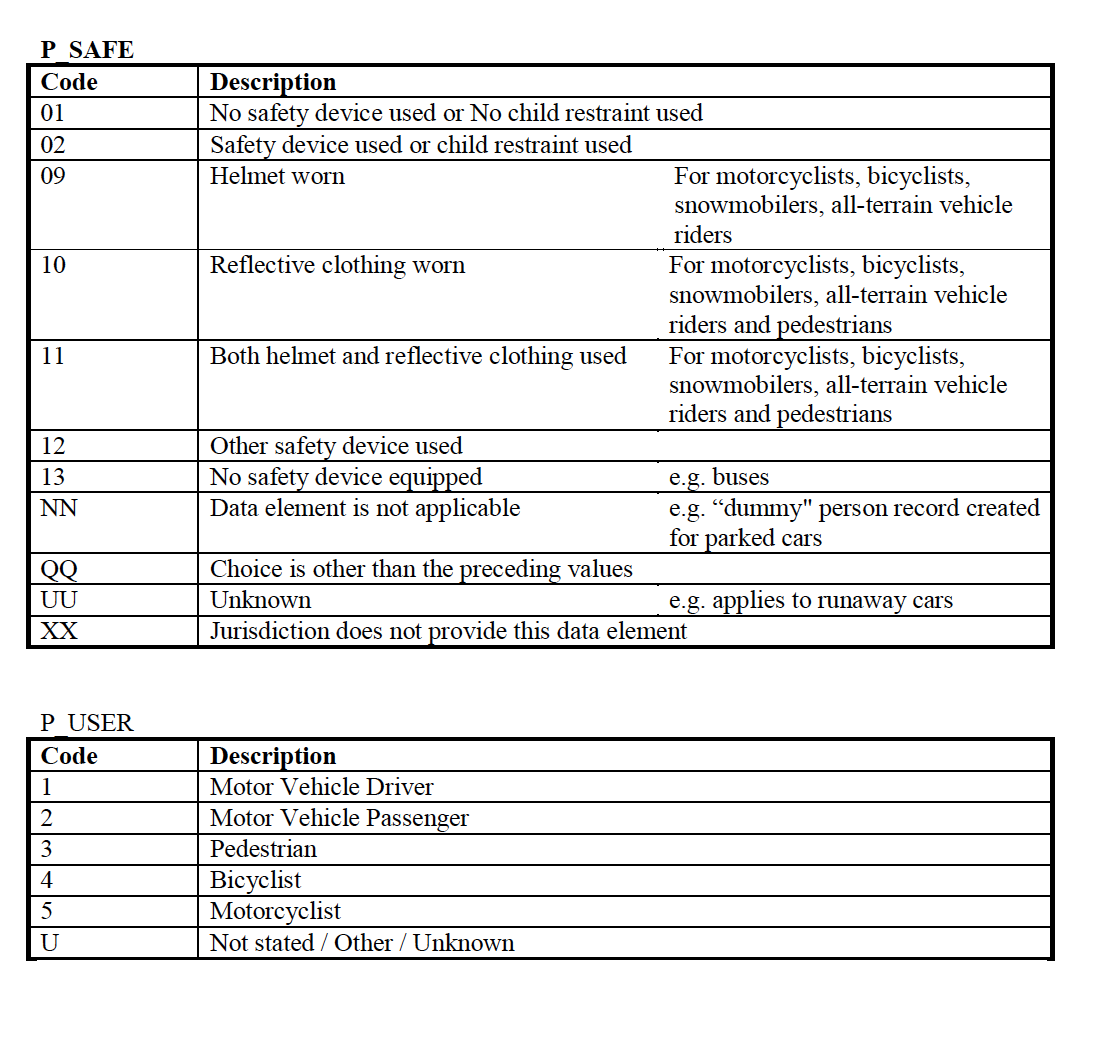

In [4]:
display(Image(filename="../images/1.png"))
display(Image(filename="../images/2.png"))
display(Image(filename="../images/3.png"))
display(Image(filename="../images/4.png"))
display(Image(filename="../images/5.png"))
display(Image(filename="../images/6.png"))
display(Image(filename="../images/7.png"))
display(Image(filename="../images/8.png"))
display(Image(filename="../images/9.png"))
display(Image(filename="../images/10.png"))
display(Image(filename="../images/11.png"))

# Análisis Exploratorio de los Datos

Inicio de carga de datos del dataset, que incluye información sobre los accidentes de tráfico ocurridos en Canadá entre 1994 y 2014.

In [5]:
# Lectura de los datos
colisiones_df = pd.read_csv('../data/NCDB_1999_to_2014.csv')
colisiones_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5860405 entries, 0 to 5860404
Data columns (total 22 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   C_YEAR  int64 
 1   C_MNTH  object
 2   C_WDAY  object
 3   C_HOUR  object
 4   C_SEV   int64 
 5   C_VEHS  object
 6   C_CONF  object
 7   C_RCFG  object
 8   C_WTHR  object
 9   C_RSUR  object
 10  C_RALN  object
 11  C_TRAF  object
 12  V_ID    object
 13  V_TYPE  object
 14  V_YEAR  object
 15  P_ID    object
 16  P_SEX   object
 17  P_AGE   object
 18  P_PSN   object
 19  P_ISEV  object
 20  P_SAFE  object
 21  P_USER  object
dtypes: int64(2), object(20)
memory usage: 983.6+ MB


In [6]:
colisiones_df.tail()

C_YEAR C_MNTH C_WDAY C_HOUR  C_SEV C_VEHS C_CONF C_RCFG C_WTHR  \
5860400    2014     UU      U     UU      2     UU     UU     01      U   
5860401    2014     UU      U     23      2     01     06     05      1   
5860402    2014     UU      U     14      2     01     02     01      1   
5860403    2014     UU      U     22      1     01     06     01      2   
5860404    2014     UU      U     22      1     01     06     01      2   

        C_RSUR  ... V_ID V_TYPE V_YEAR P_ID P_SEX P_AGE P_PSN P_ISEV P_SAFE  \
5860400      U  ...   13     07   UUUU   01     M    24    11      1     NN   
5860401      1  ...    1     14   2006   01     M    29    96      2     09   
5860402      5  ...    1     01   2006   01     F    UU    11      2     01   
5860403      4  ...    1     22   UUUU   01     M    67    12      3     01   
5860404      4  ...    1     22   UUUU   02     M    10    98      1     01   

        P_USER  
5860400      1  
5860401      5  
5860402      1  
5860403      U  
5860404      U  

[5 rows x 22 columns]

El dataset que se está usando relaciona accidente con un conjunto de variables que se configuran en tres niveles: 

 <ul>
<li> Nivel colisión</li>
<li> Nivel vehículo</li>
<li> Nivel persona</li>    
</ul>

Las variables resultan, en su amplia mayoría, categóricas y se encuentran previamente codificadas con coódigos numéricos. Esta circunstancia va a obligar a realizar cambios de encoding para eviter sesgos ante etiquetas con valores numéricos más elevados. 

A nivel general, encontramos 22 columnas, correspondientes a los distintos elementos de los niveles y 5.860.404 inputs.

Con objeto de alcanzar el fin del proyecto, a priori, se utilizará como variable objetivo C_SEV; no obstante se realizará análisis mas detallado de dicha variable para ratificar esta decisión. De igual forma, se observa conveniente prescindir en este punto de P_ISEV, puesto que es una variable que se configura o que encuentra sentido a futuro y no en el momento del accidente (las necesidades medicas son una circunstancia futura). Esta decisión también se ratificará durante análisis exploratorio más detallado.

In [7]:
colisiones_df.dtypes.sort_values().to_frame('tipo_variable').groupby(by='tipo_variable').size().to_frame('conteo').reset_index()

tipo_variable  conteo
0         int64       2
1        object      20

Sobresalen las variables de tipo object, lo que obligará a transformaciones y encoding posteriores.

## Análisis generales de la tabla

Se procede al borrado de posibles filas duplicadas. No aparecen columnas duplicadas.

In [8]:
print(colisiones_df.shape, colisiones_df.drop_duplicates().shape)

(5860405, 22) (5855336, 22)


Lo anterior confirma la existencia de filas duplicadas que, tras su borrado, confuigura el nuevo dataset con 5.860.405 inputs.

In [9]:
colisiones_df = colisiones_df.drop_duplicates()
colisiones_df.shape

(5855336, 22)

## Análisis de la variable objetivo

La variable objetivo C_SEV incluye la siguiente información:

 <ul>
<li>  Accidente con fallecidos (valor 1)</li>
<li>  Accidente sin fallecidos (valor 2)</li>    
</ul>

In [10]:
explore_target_CSEV = colisiones_df['C_SEV'].value_counts(normalize = True).mul(100).rename('percent').reset_index()
explore_target_CSEV_conteo = colisiones_df['C_SEV'].value_counts().reset_index()
explore_target_CSEV_pc = pd.merge(explore_target_CSEV, explore_target_CSEV_conteo, on=['index'], how='inner')
explore_target_CSEV_pc

index    percent    C_SEV
0      2  98.315793  5756720
1      1   1.684207    98616

Puesto que nos encontramos en un problema de clasificación, observamos como los fallecimientos poseen menores datos en la clase de fallecimientos y que va a generar problemas en el entrenamiento de la máquina.

Para conseguir que los modelos generalicen bien se procederá al balanceo de estos datos a través de selección de diversas estrategias.

In [11]:
#Plot de la variable objetivo
plot_obj = px.histogram(explore_target_CSEV_pc, x="index", y=['percent'])
plot_obj.show()

A la luz de la gráfica, el 98.32% del dataset incluye accidentes en el que no se ha producido ningun fallecimiento, frente al 1.68%. Se debe tener en cuenta que, por la configuración del dataset, existen variables dummies en las que los vehículos no involucran a personas, lo que puede aumentar considerablmente la circunstancia de no fallecidio.

## Exploración de valores nulos

Exploramos la posible exiatencia de valores nulos.

In [12]:
colisiones_df.isna().sum()

C_YEAR    0
C_MNTH    0
C_WDAY    0
C_HOUR    0
C_SEV     0
C_VEHS    3
C_CONF    0
C_RCFG    0
C_WTHR    0
C_RSUR    0
C_RALN    0
C_TRAF    0
V_ID      0
V_TYPE    0
V_YEAR    0
P_ID      0
P_SEX     0
P_AGE     0
P_PSN     0
P_ISEV    0
P_SAFE    0
P_USER    0
dtype: int64

Se debe tener en cuenta que,a pesar de la poca presencia de valores nulos, existen otras clases etiquetadas con códigos no numéricos que, en general aumentan el peso del dataset pero no conceden información relevante al modelo, bien por aglutinar otras variables o por que indican la inexistencia de información. Se procede, en la mayoría de los casos a tratarlos como valores NAs para su posterior tratamiento. 


In [13]:
null_values = ["U","UU","UUUU","X","XX"]
for columna in colisiones_df:
         colisiones_df[columna]=colisiones_df[columna].replace(null_values, np.nan)

Volvemos a contar los valores nulos de nuestro dataset.

In [14]:
colisiones_df.isna().sum()

C_YEAR         0
C_MNTH       385
C_WDAY      1323
C_HOUR     59404
C_SEV          0
C_VEHS       544
C_CONF    178785
C_RCFG    504547
C_WTHR     87953
C_RSUR     78433
C_RALN    434626
C_TRAF    223451
V_ID         433
V_TYPE     29720
V_YEAR    323296
P_ID          16
P_SEX     234351
P_AGE     376225
P_PSN      57633
P_ISEV     80665
P_SAFE    614507
P_USER    175455
dtype: int64

# Exploración gráfica de la tabla

A continuación se realiza exploración gráfica que permite relacionar los datos que tenemos con posibles circunstancias o casuísticas de un accidente. Todas ellas permiten a la compañia conocer que variables influyen más en la causación de accidentes y tomar decisiones en cuanto a posibles bonus, primas y provisiones necesarias. Se ha configurado este bloque como un conjunto de cuestiones que pueden ser anlizadas desde los datos ofrecidos por el dataset

### ¿Existe algun condicionante que determine un mayor número de accidentes?

### Variable C_MNTH

In [15]:
colisiones_df['C_MNTH'].value_counts()

8     546594
7     537261
6     519491
10    515463
9     512370
11    496606
5     467674
3     417414
2     413701
4     392134
12    275290
01    256952
12    250128
1     242500
02      9247
11      2126
Name: C_MNTH, dtype: int64

In [16]:
colisiones_df['C_MNTH']=colisiones_df['C_MNTH'].astype('float')

In [17]:
colisiones_df['C_MNTH'].value_counts()

8.0     546594
7.0     537261
12.0    525418
6.0     519491
10.0    515463
9.0     512370
1.0     499452
11.0    498732
5.0     467674
2.0     422948
3.0     417414
4.0     392134
Name: C_MNTH, dtype: int64

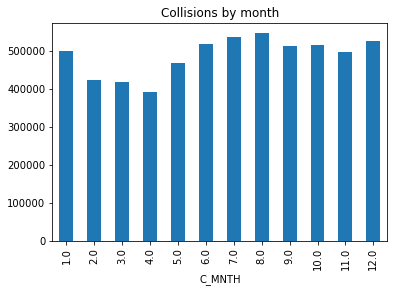

In [18]:
by_month = colisiones_df.groupby('C_MNTH')['C_SEV'].count()
plot_monthly = by_month.plot(kind = 'bar', title = 'Collisions by month');

Observamos como los mayores accidentes se producen en los meses de verano, probablemente por la mayor movilidad que se desarrolla durante este periodo. De la misma forma destaca Enero y Diciembre, en los que puede inferirse un mayor número de accidentes como consecuencia de la movilidad mayor por las fiestas navideñas o por las peores inclemencias climatóligas de los meses de invierno. Las inclimencias meteorológicas pueden causar mayor número de accidentes derivado de ellas mismas y/o a la mayor movilidad asociada a estas cuando acontecen  

### Variable C_WDAY

In [19]:
colisiones_df['C_WDAY']=colisiones_df['C_WDAY'].astype('float')

Graficamos el número de accidentes que se producen semanalmente

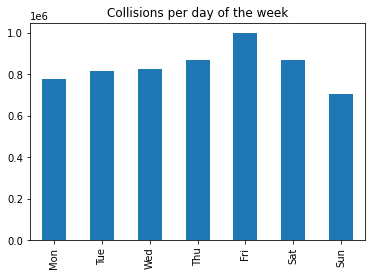

In [20]:
by_weekday = colisiones_df.groupby('C_WDAY')['C_SEV'].count()
by_weekday.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plot_weekly = by_weekday.plot(kind = 'bar',title = 'Collisions per day of the week');

Otro aspecto relevante es que el mayor numero de accidentes se produce los viernes, probablemente también derivado de la mayor movilidad que se produce este día

### Variable C_HOUR

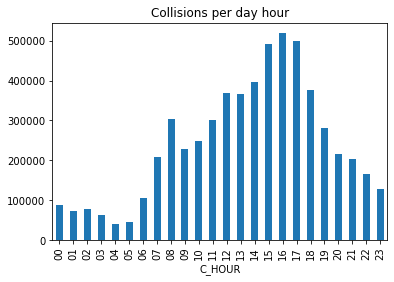

In [21]:
by_hours = colisiones_df.groupby('C_HOUR')['C_SEV'].count()
plot_hours = by_hours.plot(kind = 'bar', title = 'Collisions per day hour')

El pico de accidentes de tráficos se situa entre las 15:00 horas y las 17:00 horas y que se asocia con las mayores cuotas de movilidad en dicho periodo a consecuencia terminación de la jornada laboral y de la terminación de clases lectivas en centros educativos. 

## ¿La configuración o estado de la carretera es determinante en los accidentes?

### Variable C_RCFG

Resulta relevante el análisis exploratorio de la configuración de la carretera para conocer como ésta interfiere en los accidentes.  En este caso se estudian los valores absolutos la fatalidad en función de la configuración y los porcentajes de mortalidad asociados a ambas variables.

In [22]:
colisiones_df['C_RCFG'].unique()

array([nan, 'QQ', '01', '02', '03', '05', '04', '06', '08', '07', '09',
       '10'], dtype=object)

A continuación, ploteamos la variable de severidad en función del tipo de configuración de carretera.

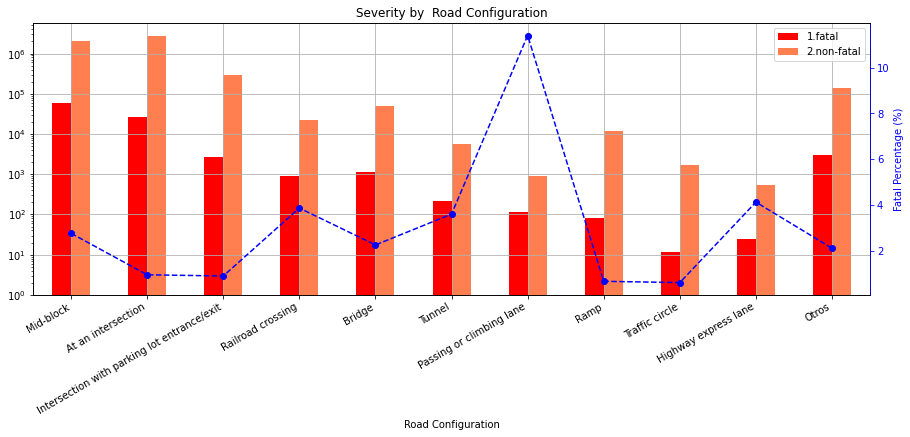

In [23]:
rcfg_type = ['Mid-block','At an intersection','Intersection with parking lot entrance/exit',
            'Railroad crossing','Bridge','Tunnel','Passing or climbing lane',
             'Ramp','Traffic circle','Highway express lane', 'Otros'
             ]

sev_car = colisiones_df.groupby(['C_RCFG','C_SEV']).size().unstack().fillna(0)
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.set_ylabel('Fatal Percentage (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')


sev_car.plot(kind='bar',rot=30,log=True,color=['red','coral'],figsize=(15,5),
         title='Severity by  Road Configuration', ax=ax1)
ax1.grid(axis='both')
ax1.legend(['1.fatal','2.non-fatal'])
ax1.set_xticklabels(rcfg_type,ha='right')
ax1.set_xlabel('Road Configuration')

se1 = sev_car[1]/(sev_car[1]+sev_car[2])*100
se1.plot(c='b', style='o--', ax=ax2)

plt.xticks(np.arange(0,11),rcfg_type);

Observamos como el mayor numero de accidentes se produce en las medianas y en las intersecciones, sin embargo, el porcentaje de mortalidad en este caso es relativamente bajo con respecto a los cambios de rasante, donde el porcentaje de mortalidad es mayor. Esto quiere decir que la posibilidad de ocurrencia de un accidente en cambio de rasante es baja pero que, de producirse, posee altas probabilidades de resultar mortal.

### ¿Existe algún tipo de vehículo con mayor propensión a la ocurrencia de accidentes?

### Variable V_TYPE

La variable V_TYPE da información sobre el tipo de vehículo involucrado en el accidente. 

In [24]:
type_of_vehicle = colisiones_df.groupby('V_TYPE')['C_SEV'].count()
type_of_vehicle

V_TYPE
01    4823371
05      66069
06     175406
07      88011
08      70520
09      20906
10        897
11      51222
14     122682
16       9717
17     122626
18       3132
19       2001
20       7632
21        825
22       4580
23       3073
NN     227551
QQ      25395
Name: C_SEV, dtype: int64

<AxesSubplot:xlabel='V_TYPE'>

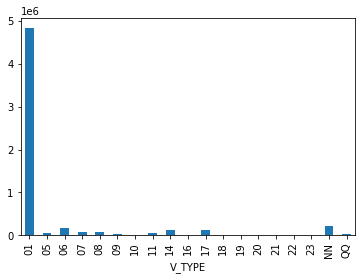

In [25]:
type_of_vehicle.plot(kind = 'bar')

Se observa que los vehículos con mayor numero de accidentes son los ligeros, no obstante se proceda a graficar los datos de manera detallada.

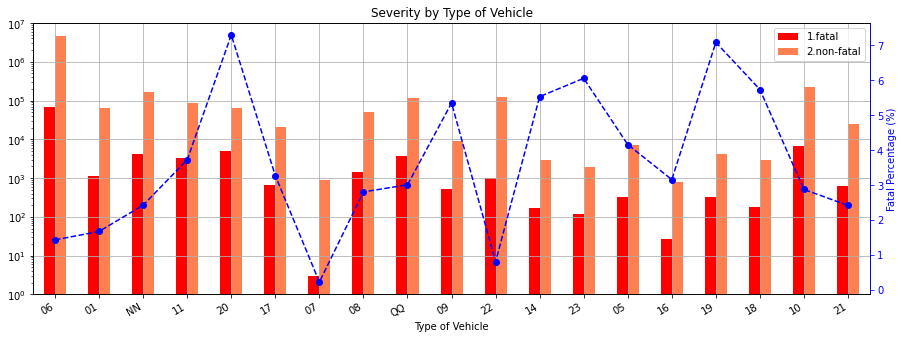

In [26]:
categorias_veh = colisiones_df['V_TYPE'].dropna().unique()
type_veh = colisiones_df.groupby(['V_TYPE','C_SEV']).size().unstack().fillna(0)
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.set_ylabel('Fatal Percentage (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')


type_veh.plot(kind='bar',rot=30,log=True,color=['red','coral'],figsize=(15,5),
         title='Severity by Type of Vehicle', ax=ax1)
ax1.grid(axis='both')
ax1.legend(['1.fatal','2.non-fatal'])
ax1.set_xticklabels(type_of_vehicle,ha='right')
ax1.set_xlabel('Type of Vehicle')

se1 = type_veh[1]/(type_veh[1]+type_veh[2])*100
se1.plot(c='b', style='o--', ax=ax2)

plt.xticks(np.arange(0,19),categorias_veh);

En términos relativos, las mayores cuotas de siniestralidad con fallecidos tienen lugar en accidentes con vehículos de granja (19) y en autocaravanas homologadas (20). Este porcentaje de siniestralidad puede encontrar sentido a consecuencia del no uso de elementos de seguridad apropiados o de la no adaptación apropiada. En términos absolutos, el mayor número de accidentes deriva de camiones y furgonetas y que encuentra causa en una posible mayor movilidad de este tipo de vehículos comom consecuencia del transporte de mercancias terrestre.

### Variable P_ISEV

In [27]:
injuries = colisiones_df.groupby('P_ISEV')['P_ISEV'].count()
injuries

P_ISEV
1    2372821
2    3070875
3      40347
N     290628
Name: P_ISEV, dtype: int64

<AxesSubplot:xlabel='P_ISEV'>

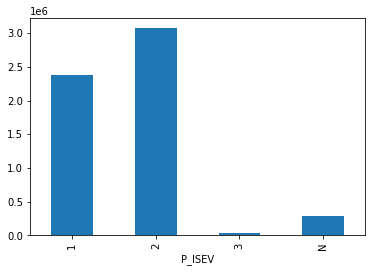

In [28]:
injuries.plot(kind='bar')

P_ISEV da información sobre el alcance del accidente. En este caso, teniendo en cuenta el dataset, el número de fallecidos (3) es 40.347 personas, mientras que el número de heridos asciende hasta 3.070.875 personas. La variable N hace mención a los coches aparcados.

Cabe destacar la diferencia con respecto a C_SEV, que agrupa por accidentes

### ¿Los elementos de seguridad son un elemento determinante en la seguridad de los conductores y el resto de ocupantes?

### Variable P_SAFE

In [29]:
safe_dev = colisiones_df.groupby('P_SAFE')['C_SEV'].count()
safe_dev

P_SAFE
01     198490
02    4160768
09      96325
10        112
11         11
12      18316
13     148321
NN     571401
QQ      47085
Name: C_SEV, dtype: int64

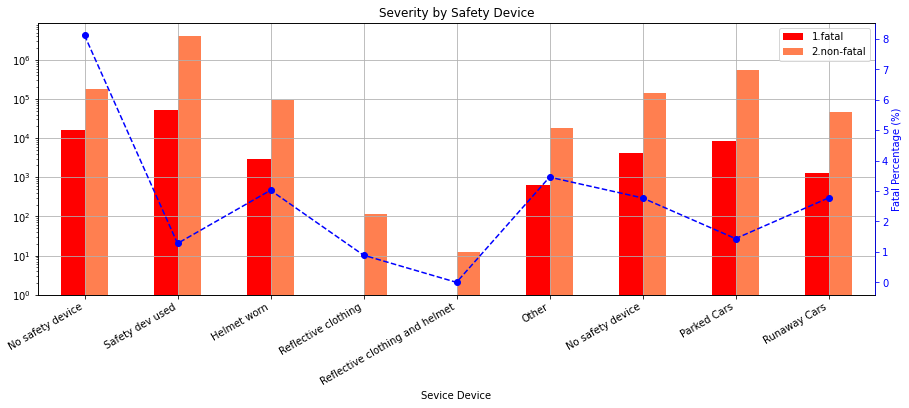

In [30]:
safety_dev = ['No safety device', 'Safety dev used', 'Helmet worn', 'Reflective clothing',
              'Reflective clothing and helmet',
             'Other', 'No safety device', 'Parked Cars', 'Runaway Cars'
             ]

df_safe = colisiones_df.groupby(['P_SAFE','C_SEV']).size().unstack().fillna(0)
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.set_ylabel('Fatal Percentage (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')


df_safe.plot(kind='bar',rot=30,log=True,color=['red','coral'],figsize=(15,5),
         title='Severity by Safety Device', ax=ax1)
ax1.grid(axis='both')
ax1.legend(['1.fatal','2.non-fatal'])
ax1.set_xticklabels(safety_dev,ha='right')
ax1.set_xlabel('Sevice Device')

#Calculate the percentage of fatal injury in all accidents by different road surface type,
# and plot to right axis.
se1 = df_safe[1]/(df_safe[1]+df_safe[2])*100
se1.plot(c='b', style='o--', ax=ax2)

plt.xticks(np.arange(0,9),safety_dev); 

Si analizamos los accidentes en función de los elementos de seguridad se observa, de forma lógica, como los accidentes en los que no existen elementos de seguridad, la letalidad es mayor

### ¿La posición de la persona y/o ocupante influye en la siniestralidad?

### Variable P_USER

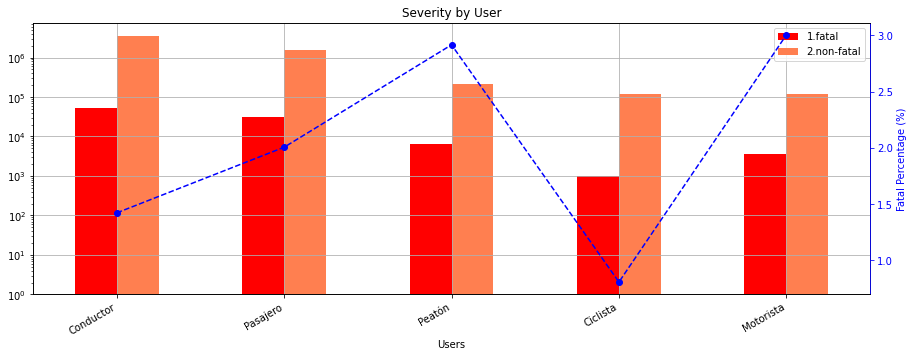

In [31]:
user_type = ['Conductor', 'Pasajero', 'Peatón', 'Ciclista','Motorista']

df_user = colisiones_df.groupby(['P_USER','C_SEV']).size().unstack().fillna(0)
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.set_ylabel('Fatal Percentage (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')

df_user.plot(kind='bar',rot=30,log=True,color=['red','coral'],figsize=(15,5),
         title='Severity by User', ax=ax1)
ax1.grid(axis='both')
ax1.legend(['1.fatal','2.non-fatal'])
ax1.set_xticklabels(user_type,ha='right')
ax1.set_xlabel('Users')

se1 = df_user[1]/(df_user[1]+df_user[2])*100
se1.plot(c='b', style='o--', ax=ax2)

plt.xticks(np.arange(0,5),user_type); 

La mayor siniestralidad se encuentra en los conductores en térmonos absolutos, llegando a valores parecidos con los pasajeros; sin embargo, la letalidad resulta mayor en los pasajeros que en los conductores. Cabe destacar también el alto porcentaje de mortalidad en el caso de peatones y de motorista y que encuentra lógica como consecuencia de los menores elementos de seguridad y la mayor desprotección frente accidentes.

### ¿La situación climatológicas pueden condicionar los accidentes y la letalidad de los mismos?

### Variable C_WTHR

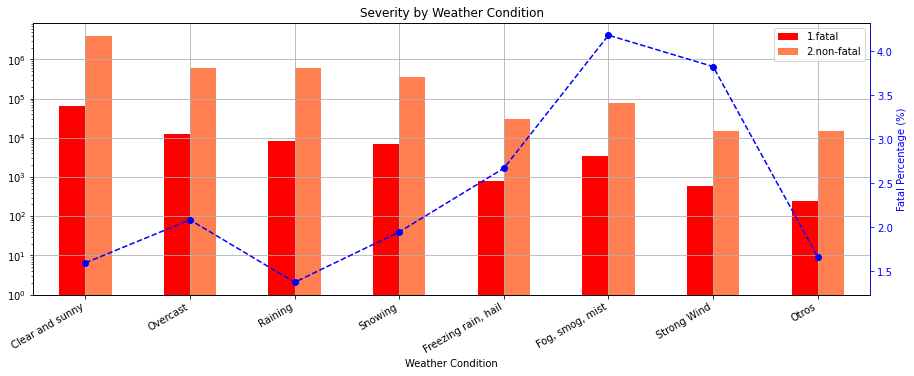

In [32]:
clima =  ['Clear and sunny','Overcast','Raining','Snowing','Freezing rain, hail','Fog, smog, mist',
            'Strong Wind', 'Otros']

df_clima = colisiones_df.groupby(['C_WTHR','C_SEV']).size().unstack().fillna(0)
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.set_ylabel('Fatal Percentage (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')

df_clima.plot(kind='bar',rot=30,log=True,color=['red','coral'],figsize=(15,5),
         title='Severity by Weather Condition', ax=ax1)
ax1.grid(axis='both')
ax1.legend(['1.fatal','2.non-fatal'])
ax1.set_xticklabels(clima,ha='right')
ax1.set_xlabel('Weather Condition')

se1 = df_clima[1]/(df_clima[1]+df_clima[2])*100
se1.plot(c='b', style='o--', ax=ax2)

plt.xticks(np.arange(0,8),clima); 

La siniestralidad con respecto al clima indica que, en términos absolutos del dataset, han existido más accidentes en días soleados, sin embargo, este dato contrasta con el valor en términos relativos de mortalidad, alcanzando los porcentajes más bajos del conjunto de variables asociadas al tiempo. Se debe destacar también que los accidentes en días de niebla y de viento poseen el porcentaje más elevado de accidentes mortales del conjunto de datos disponibles.

### Realación entre variable C_WTHR y C_RSUR

In [33]:
wthrxsur = colisiones_df.groupby('C_WTHR')['C_RSUR'].count()
wthrxsur

C_WTHR
1    4057968
2     597859
3     598910
4     352861
5      30137
6      81981
7      15068
Q      14634
Name: C_RSUR, dtype: int64

In [34]:
wthrxsur = colisiones_df.groupby('C_WTHR').count()
wthrxsur

C_YEAR   C_MNTH   C_WDAY   C_HOUR    C_SEV   C_VEHS   C_CONF  \
C_WTHR                                                                  
1       4070396  4070250  4069462  4031830  4070396  4070132  3950097   
2        600166   600160   600153   591887   600166   600147   575392   
3        599623   599617   599571   593663   599623   599585   585261   
4        354314   354296   354268   351252   354314   354301   345051   
5         30310    30310    30309    29982    30310    30306    29607   
6         82407    82406    82402    81591    82407    82402    80436   
7         15157    15157    15155    15011    15157    15157    14781   
Q         15010    15008    15007    14865    15010    15010    14576   

         C_RCFG   C_RSUR   C_RALN  ...     V_ID   V_TYPE   V_YEAR     P_ID  \
C_WTHR                             ...                                       
1       3707077  4057968  3755253  ...  4070048  4050750  3847989  4070381   
2        576954   597859   591615  ...   600145   597641   557775   600166   
3        569172   598910   577634  ...   599598   596666   568727   599623   
4        323205   352861   330668  ...   354288   352880   339699   354313   
5         27432    30137    28973  ...    30310    30170    28920    30310   
6         77872    81981    80568  ...    82399    81983    78260    82407   
7         14075    15068    14265  ...    15157    15095    14496    15157   
Q         10724    14634    10547  ...    15009    14933    14446    15010   

          P_SEX    P_AGE    P_PSN   P_ISEV   P_SAFE   P_USER  
C_WTHR                                                        
1       3910251  3804556  4034551  4018394  3645242  3954436  
2        568415   560172   592180   589969   530694   578881  
3        581496   567512   596831   595446   546982   587335  
4        344074   336509   351344   350035   324576   344342  
5         29116    28517    29922    29845    27640    29183  
6         79530    78047    81099    81138    75009    78842  
7         14582    14227    14878    14841    13530    14521  
Q         14725    14268    15001    14882    13644    14639  

[8 rows x 21 columns]

<AxesSubplot:xlabel='C_WTHR'>

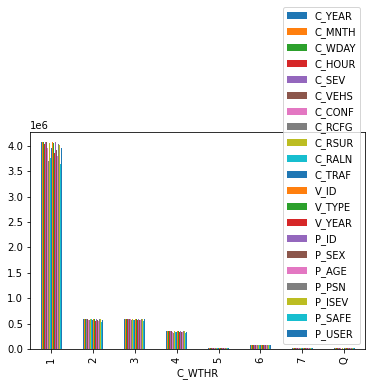

In [35]:
wthrxsur.plot(kind = 'bar')

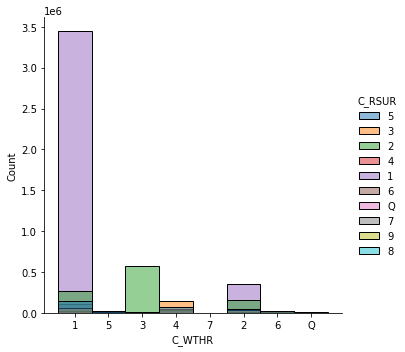

In [36]:
sns.displot(colisiones_df, x = 'C_WTHR', hue = 'C_RSUR')

El gráfico anterior relaciona las condiciones climatológicas y el estado de la carretera. Se observsa como, de forma lógico, las buenas condiciones climatóligas generan un mejor estado de la carretera. 

### ¿La antiguedad del vehículo es determinante en la siniestralidad y en la mortalidad de los accidentes?

Para este caso vamos a analizar una nueva variable derivada de C_YEAR y de V_YEAR con objeto de determinar la edad del vehículo en el momento del accidente. Esta vriable necesita un tratamiento previo en cuanto a transformación, tratamiento de NAs y diferencias que serán usado solo para el graficado.

In [37]:
collision_df_plot = colisiones_df

null_values = ["U","UU","UUUU","X","XX", "QQ", "Q", "N", "NN", "NNNN"]
for columna in collision_df_plot:
         collision_df_plot[columna]=collision_df_plot[columna].replace(null_values, np.nan)
        

collision_df_plot = colisiones_df.dropna(axis=0)

In [38]:
collision_df_plot['C_V_YEAR']= collision_df_plot['C_YEAR'].astype('int64') - collision_df_plot['V_YEAR'].astype('int64')

<AxesSubplot:xlabel='C_V_YEAR', ylabel='Fatal Percentage (%)'>

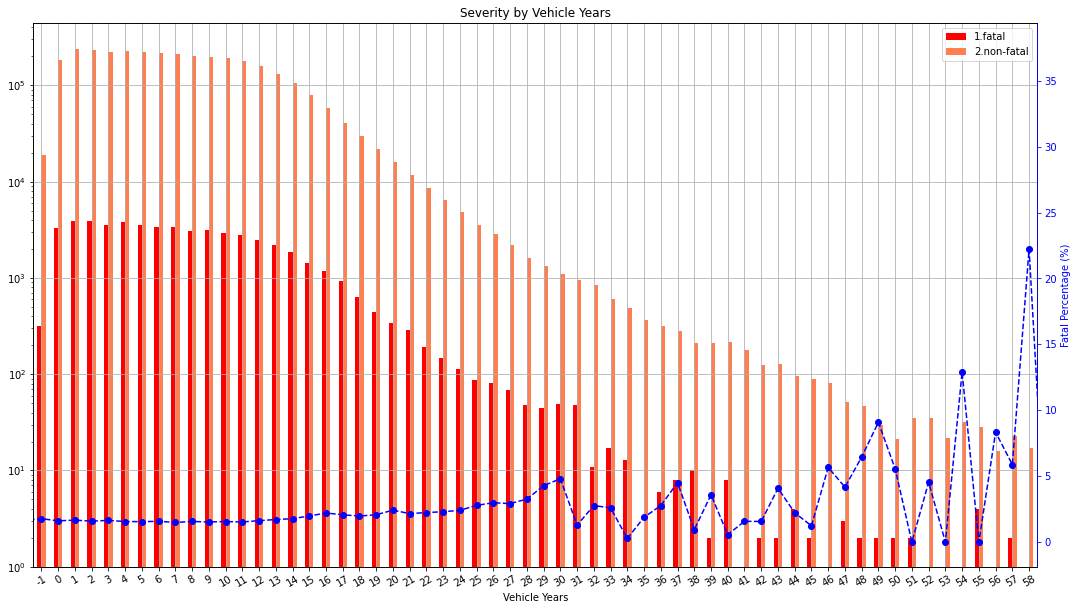

In [39]:
df_antiguedad = collision_df_plot.groupby(['C_V_YEAR','C_SEV']).size().unstack().fillna(0)
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.set_ylabel('Fatal Percentage (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')

df_antiguedad[1:61].plot(kind='bar',rot=30,log=True,color=['red','coral'],figsize=(18,10),
         title='Severity by Vehicle Years', ax=ax1)
ax1.grid(axis='both')
ax1.legend(['1.fatal','2.non-fatal'])
ax1.set_xlabel('Vehicle Years')

se1 = df_antiguedad[1]/(df_antiguedad[1]+df_antiguedad[2])*100
se1.plot(c='b', style='o--', ax=ax2)

El gráfico arroja información sobre diversos aspectos. En primer lugar, podemos concluir que Canadá tiene un parque móvil relativamente nuevo, con mayores numeros de accidentes asociados a coches con una antiguedad menor a 10 años. Además, se observa un descenso paulatino en el número de accidentes a partir de coches con una antiguedad de 12-15 años, lo que transfiere información sobre la media de vida útil de los vehículos del parque móvil de Canadá. Finalmente, el gráfico también arroja información sobre la mortalidad en función del año de antiguedad del vehículo. 

Relacionando esto con negocios aseguradores, no se observan datos suficientes a proiori que permitan justificar la posible imposición de primas o de bonus en relación a la antiguedad del vehículo, lo que si se extrae de la gráfica es que la mortalidad aumenta abrupatamente a partir de vehículos que tengan una antiguedad mayor de 29 años, lo que si justifica la posible existencia de mayores primas.

### ¿Que características asociadas a los conductores influyen en la causación de un accidente?

<AxesSubplot:xlabel='P_AGE', ylabel='Fatal Percentage (%)'>

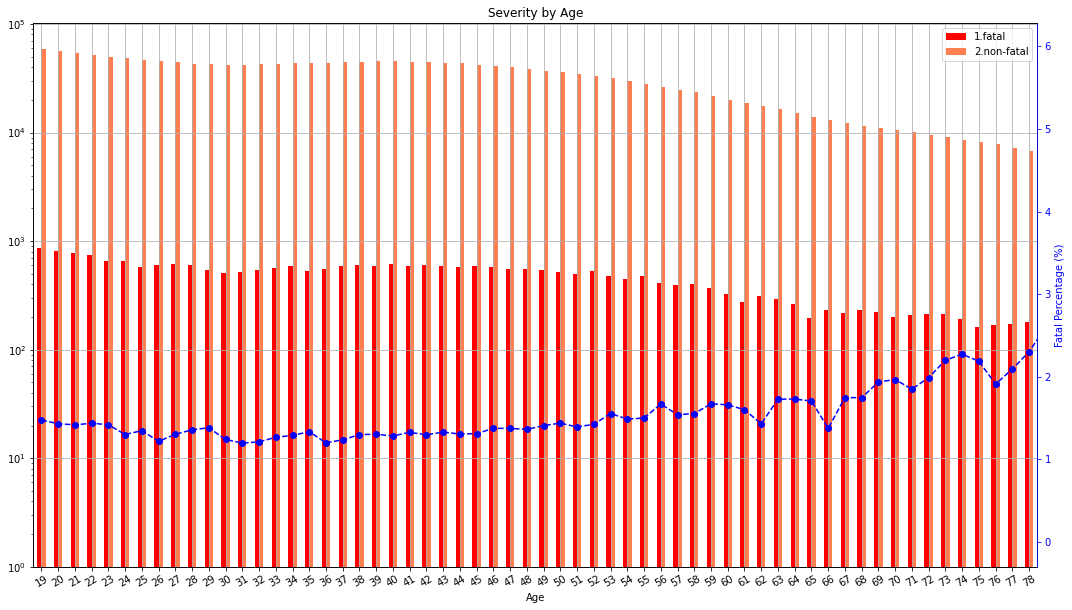

In [40]:
df_edad = collision_df_plot[(collision_df_plot.P_USER.astype("int64") == 1) & (collision_df_plot.P_AGE.astype("int64") > 18)].groupby(['P_AGE','C_SEV']).size().unstack().fillna(0)
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.set_ylabel('Fatal Percentage (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')

df_edad[1:61].plot(kind='bar',rot=30,log=True,color=['red','coral'],figsize=(18,10),
         title='Severity by Age', ax=ax1)
ax1.grid(axis='both')
ax1.legend(['1.fatal','2.non-fatal'])
ax1.set_xlabel('Age')

se1 = df_edad[1]/(df_edad[1]+df_edad[2])*100
se1.plot(c='b', style='o--', ax=ax2)

Puede observarse como la mortalidad asociada a los accidentes sigue una relación directa al aumento de la edad. El gráfico anterior filtra por conductores mayores de 18 años involucrados en un accidente y evidencia cómo conforme aumenta la edad, la mortalidad resulta mayor. A efectos de la aseguradora, entendemos que se justifica una mayor prima en pólizas en las que el asegurado conductor tenga una edad más avanzada, sobre todo en el tramos a partir de 50 años.

<AxesSubplot:xlabel='P_AGE', ylabel='Fatal Percentage (%)'>

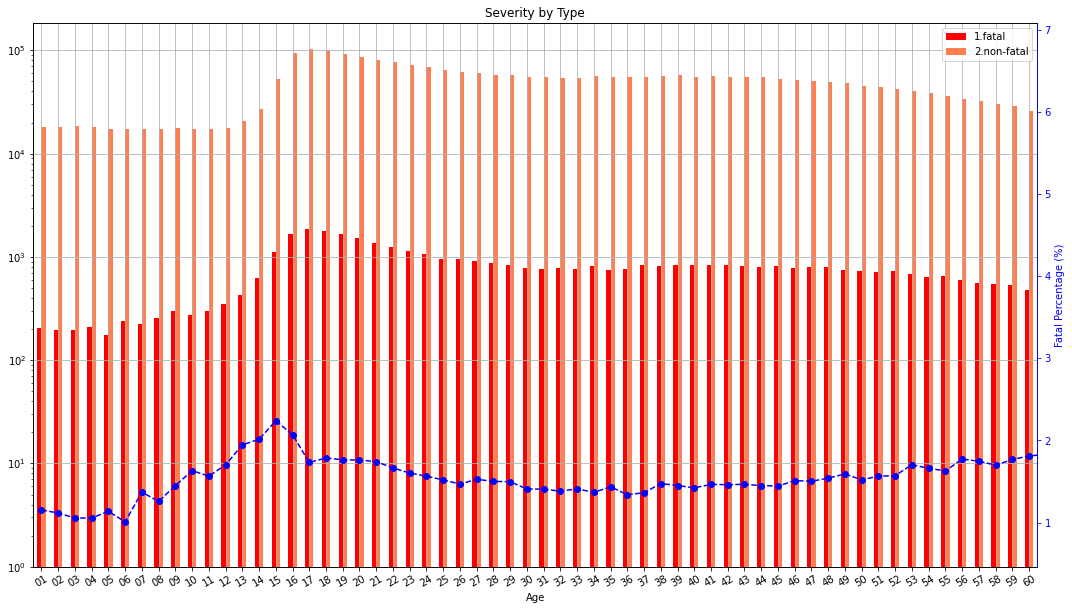

In [41]:
df_edad = collision_df_plot.groupby(['P_AGE','C_SEV']).size().unstack().fillna(0)
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.set_ylabel('Fatal Percentage (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')

df_edad[1:61].plot(kind='bar',rot=30,log=True,color=['red','coral'],figsize=(18,10),
         title='Severity by Type', ax=ax1)
ax1.grid(axis='both')
ax1.legend(['1.fatal','2.non-fatal'])
ax1.set_xlabel('Age')

se1 = df_edad[1]/(df_edad[1]+df_edad[2])*100
se1.plot(c='b', style='o--', ax=ax2)

Sorprendemente si analizamos la edad en función de los accidentes aparece un pico de fallecimientos entre entre los 12 y los 16 años. Se ha analizado la legislación de tráfico de Canada encontrando que en algunos estados como Alberta o Nuevo Brunswick, las licencias de moto se conceden a partir de esta edad, lo que podría explicar dichos accidentes.

# Tratamiento de los datos

## Preprocesamiento de variables

Como el objetivo principal del modelo es saber si en un accidente se van a producir o no fallecimientos, en las variables donde se identifica a la persona, los datos que pertenecen a coches, es decir, todos aquellos accidentes entre una persona y un coche aparcado, no nos sirven. Por ello, procedemos a eliminarlos.

### Variable P_SEX

Se considera adecuado y relevante mantener la variable P_SEX, en cuyo caso es necesa realizar transformación y prescindir de valores que no resulten de los etiquetados hombre/mujer. 

In [42]:
colisiones_df['P_SEX'].unique()

array(['M', 'F', nan], dtype=object)

In [43]:
colisiones_df['P_SEX'] = colisiones_df['P_SEX']\
                                .map({'M':'M', 'F':'F', np.nan:'Coche', 'N':'Coche'}).astype(object)

In [44]:
colisiones_df = colisiones_df.drop(colisiones_df.loc[colisiones_df["P_SEX"] == "Coche"].index, inplace = False)

In [45]:
colisiones_df['P_SEX'].unique()

array(['M', 'F'], dtype=object)

In [46]:
colisiones_df['P_SEX'].value_counts()

M    3167673
F    2438532
Name: P_SEX, dtype: int64

### Variable P_ID

Las etiquetas NN de la variables ID no nos trasladan ningún tipo de información al modelo por lo que se va a prescindir de ella. La variable ID, aunque se conoce el poco peso por la variabilidad de los datos, se mantiene para posterior eliminado.

In [47]:
colisiones_df["P_ID"].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33',
       '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44',
       '46', '47', '48', '49', '50', '52', '55', '56', '57', '61', '62',
       '63', '65', '66', '67', '68', '69', '70', '71', '72', '76', '77',
       '78', '79', '80', '81', '82', '85', '86', '88', '90', '91', '93',
       '94', '95', '45', '51', nan, '53', '54', '58', '59', '60', '99',
       '64', '73', '74', '75', '83', '84', '87', '89', '92'], dtype=object)

In [48]:
colisiones_df = colisiones_df.dropna(axis=0, subset=['P_ID'])
colisiones_df = colisiones_df.drop(colisiones_df.loc[colisiones_df["P_ID"] == "NN"].index, inplace = False)

In [49]:
colisiones_df["P_ID"].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33',
       '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44',
       '46', '47', '48', '49', '50', '52', '55', '56', '57', '61', '62',
       '63', '65', '66', '67', '68', '69', '70', '71', '72', '76', '77',
       '78', '79', '80', '81', '82', '85', '86', '88', '90', '91', '93',
       '94', '95', '45', '51', '53', '54', '58', '59', '60', '99', '64',
       '73', '74', '75', '83', '84', '87', '89', '92'], dtype=object)

### Variable P_PSN

La variable P_PSN indica el lugar ocupado por la persona en el momento del accidente, circunstancia que lleva a prescindir de aquellas que estén etiqueta con NN por no incorporar ningún tipo de información. El resto de datos se mantienen para codificación posterior por considerarse relevantes.

In [50]:
colisiones_df = colisiones_df.drop(colisiones_df.loc[colisiones_df["P_PSN"] == "NN"].index, inplace = False)
colisiones_df = colisiones_df.dropna(axis=0, subset=['P_PSN'])

In [51]:
colisiones_df['P_PSN'].unique()

array(['11', '13', '99', '23', '98', '21', '22', '12', '96', '32', '31',
       '33', '97'], dtype=object)

In [52]:
colisiones_df['P_PSN'].value_counts()

11    3765422
13     874915
23     255272
21     213205
99     207171
22      88947
12      85982
96      42023
32      28252
98       6466
33       5722
31       4535
97        189
Name: P_PSN, dtype: int64

### Variable P_ISEV

La variable P_ISEV se considera redundante respecto a la variable objetivo, lo que nos lleva a prescindir de ella. Además, ésta mezcla información respecto a daños en vehículos, por lo que se considera apropiado su eliminación.

In [53]:
colisiones_df = colisiones_df.drop(colisiones_df.loc[colisiones_df["P_ISEV"] == "N"].index, inplace = False)
colisiones_df = colisiones_df.dropna(axis=0, subset=['P_ISEV'])

In [54]:
colisiones_df['P_ISEV'].unique()

array(['1', '2', '3'], dtype=object)

In [55]:
colisiones_df['P_ISEV'].value_counts()

2    3028288
1    2300134
3      40081
Name: P_ISEV, dtype: int64

### Variable P_SAFE

P_SAFE muestra información sobre el elemento de seguridad que tiene protagonismo en el accidente. Se ha demostrado mediante representación gráfica que los accidentes con menor mortalidad son aquellos en los que los elementos de seguridad están presente, por lo que se mantiene como variable predictora del modelo. No obstante, el peso de las variables incorporadas al conjunto de modelos serán analizadas en el posterior bloque de interpretabilidad

In [56]:
colisiones_df = colisiones_df.drop(colisiones_df.loc[colisiones_df["P_SAFE"] == "NN"].index, inplace = False)
colisiones_df = colisiones_df.dropna(axis=0, subset=['P_SAFE'])

In [57]:
colisiones_df['P_SAFE'].unique()

array(['02', '01', '13', '12', '09', '10', '11'], dtype=object)

### Variable P_USER

La variable P_USER determina si la persona accidentada resultaba conductora, motorista, peatón, ciclista. Se considera el peso que tiene dicha variable predictora, por lo que no se considera óptimo ni adecuadon su agrupación o eliminado. 

In [58]:
colisiones_df['P_USER'].value_counts(normalize = False).reset_index()

index   P_USER
0     1  2862320
1     2  1447892
2     3    88811
3     5    73466
4     4    51053

Tras la eliminación de columnas realizamos test para comprobar la configuración de la variable objetivo, observándose que no han existido cambios relevantes en la configuración inicial. Aún así se observa necesario la realizar rebalanceo para alcanzar un entrenamiento óptimo. 

In [59]:
colisiones_df['C_SEV'].value_counts()

2    4494181
1      76259
Name: C_SEV, dtype: int64

In [60]:
colisiones_df['C_SEV'] = colisiones_df.C_SEV.replace(to_replace=[2], value=[0])

In [61]:
colisiones_df['C_SEV'].value_counts()

0    4494181
1      76259
Name: C_SEV, dtype: int64

In [62]:
explore_target_CSEV3 = colisiones_df['C_SEV'].value_counts(normalize = True).mul(100).rename('percent').reset_index()
explore_target_CSEV_conteo3 = colisiones_df['C_SEV'].value_counts().reset_index()
explore_target_CSEV_pc3 = pd.merge(explore_target_CSEV3, explore_target_CSEV_conteo3, on=['index'], how='inner')
explore_target_CSEV_pc3

index    percent    C_SEV
0      0  98.331474  4494181
1      1   1.668526    76259

Se prescinde en V_TYPE y V_YEAR de etiquetas que no conceden información

In [63]:
columna = ["V_TYPE", "V_YEAR"]
peatones = ["NN","NNNN"]
for columna in colisiones_df:
         colisiones_df[columna]=colisiones_df[columna].replace(peatones, "0")

In [64]:
colisiones_df['V_TYPE'].unique()

array(['01', '06', nan, '20', '17', '07', '08', '11', '09', '22', '14',
       '23', '05', '16', '19', '18', '10', '21'], dtype=object)

## Nueva variable C_V_YEAR

Se ha observado que el año de antiguedad del vehículo influye notablemente en la siniestralidad, por lo que se considera adecuado incluir dichas variables en los modelos como posible variable predictora. En este caso el tratamiento de valores NAs resulta más caprichoso porque la asignación de un valor medio del conjunto del dataset nos podría llevar a valores negativos o outlier como consecuencia de asignar valores no acordes con la realidad y que se derivan de computar la diferencia entre ambas variables.

In [65]:
colisiones_df['V_YEAR'].isnull().sum()

247362

In [66]:
colisiones_df = colisiones_df.dropna(axis=0, subset=['V_YEAR'])

In [67]:
colisiones_df['V_YEAR'].isnull().sum()

0

In [68]:
colisiones_df['V_YEAR'].unique()

array(['1987', '1997', '1985', '1988', '1993', '1992', '1998', '1994',
       '1996', '1995', '1986', '1983', '1990', '1989', '1991', '1999',
       '1984', '1965', '1968', '1981', '1976', '1979', '1972', '1977',
       '1982', '1975', '1978', '1974', '1980', '1967', '1973', '1970',
       '1971', '1962', '1969', '1966', '1945', '2000', '1950', '1964',
       '1959', '1955', '1958', '1903', '1909', '1923', '1960', '1963',
       '1914', '1908', '1953', '1906', '1961', '1925', '1949', '1938',
       '1907', '1952', '1904', '1917', '1944', '1956', '1930', '1931',
       '1939', '1951', '1946', '1947', '1957', '1954', '1943', '1901',
       '1948', '1937', '1905', '1935', '1926', '1941', '1932', '1912',
       '1920', '1933', '1919', '2001', '1913', '1940', '1927', '2002',
       '1916', '1929', '1928', '1942', '1918', '2003', '1924', '1922',
       '1915', '1934', '2004', '2005', '2006', '2007', '2008', '1911',
       '2009', '2010', '2011', '1936', '2012', '1921', '2013', '2014',
      

In [69]:
colisiones_df['V_YEAR']=colisiones_df['V_YEAR'].astype('int')

In [70]:
colisiones_df['V_YEAR'].unique()

array([1987, 1997, 1985, 1988, 1993, 1992, 1998, 1994, 1996, 1995, 1986,
       1983, 1990, 1989, 1991, 1999, 1984, 1965, 1968, 1981, 1976, 1979,
       1972, 1977, 1982, 1975, 1978, 1974, 1980, 1967, 1973, 1970, 1971,
       1962, 1969, 1966, 1945, 2000, 1950, 1964, 1959, 1955, 1958, 1903,
       1909, 1923, 1960, 1963, 1914, 1908, 1953, 1906, 1961, 1925, 1949,
       1938, 1907, 1952, 1904, 1917, 1944, 1956, 1930, 1931, 1939, 1951,
       1946, 1947, 1957, 1954, 1943, 1901, 1948, 1937, 1905, 1935, 1926,
       1941, 1932, 1912, 1920, 1933, 1919, 2001, 1913, 1940, 1927, 2002,
       1916, 1929, 1928, 1942, 1918, 2003, 1924, 1922, 1915, 1934, 2004,
       2005, 2006, 2007, 2008, 1911, 2009, 2010, 2011, 1936, 2012, 1921,
       2013, 2014, 2015])

In [71]:
colisiones_df['C_V_YEARS'] = colisiones_df['C_YEAR'] - colisiones_df['V_YEAR']
colisiones_df['C_V_YEARS'].unique()

array([ 12,   2,  14,  11,   6,   7,   1,   5,   3,   4,  13,  16,   9,
        10,   8,   0,  15,  34,  31,  18,  23,  20,  27,  22,  17,  24,
        21,  25,  19,  32,  26,  29,  28,  37,  30,  33,  54,  -1,  49,
        35,  40,  44,  41,  96,  90,  76,  39,  36,  85,  91,  46,  93,
        38,  74,  50,  61,  92,  47,  95,  82,  55,  43,  69,  68,  60,
        48,  53,  52,  42,  45,  56,  98,  51,  62,  94,  64,  73,  58,
        67,  87,  79,  66,  80,  83,  86,  75,  -2,  59,  84,  71,  63,
        70,  77,  65,  72,  81,  57, 100,  99, 101,  78,  89,  97,  88,
       103], dtype=int64)

Una vez que se ha obtenido la nueva variable se procede a prescindir de ambas 

In [72]:
colisiones_df = colisiones_df.drop(['V_YEAR', 'C_YEAR'], axis=1)

In [73]:
colisiones_df.isna().sum()

C_MNTH          132
C_WDAY          617
C_HOUR        38364
C_SEV             0
C_VEHS            4
C_CONF       269811
C_RCFG       461719
C_WTHR        66459
C_RSUR       199026
C_RALN       361779
C_TRAF       195646
V_ID              0
V_TYPE        25250
P_ID              0
P_SEX             0
P_AGE         85181
P_PSN             0
P_ISEV            0
P_SAFE            0
P_USER        38718
C_V_YEARS         0
dtype: int64

## Matriz de correlaciones

Realizamos aqui la matriz de correlaciones despues de la transformacion para poder ver la correlacion de todas las variables en su forma definitiva

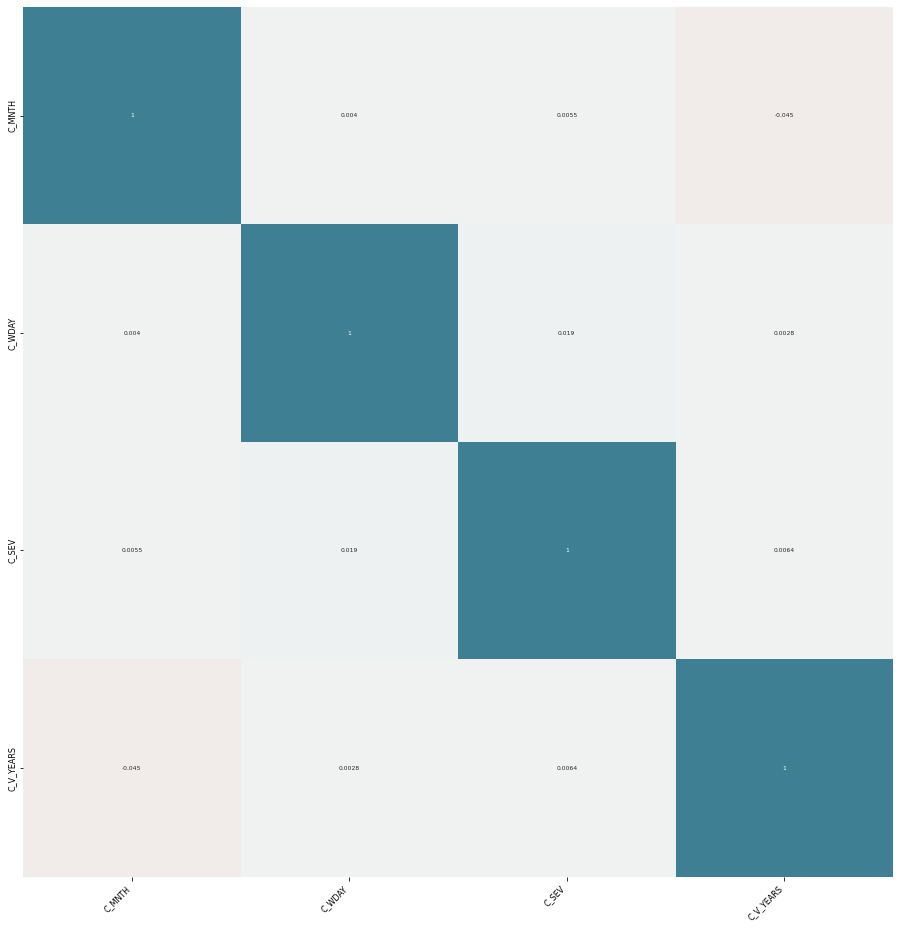

In [74]:
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)



corr_matrix = colisiones_df.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 16))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)

# Codificación de variables

Puesto que incluimos en el conjunto de variables categóricas, se opta por realizar una codificación basada en la media y que tiene efectos óptimos para la clasificación en base a árboles de decisión. En este caso la codificación se realiza determinando la probabilidad de que un determinado dato pertenezca a una de las clases y usando dicha probabilidad como etiqueta.

Se han realizado pruebas con codificación One Hot Encoding, no obteniendo resultados óptimos. Además, se incluyen un número delimitado de variables que no incluyen las temporales, puesto que van a ser objeto de Cyclical encoding.

## Mean Encoding

In [75]:
cols=['C_SEV', 'C_VEHS', 'C_CONF', 'C_RCFG',
       'C_WTHR', 'C_RSUR', 'C_RALN', 'C_TRAF', 'V_ID', 'V_TYPE', 'P_ID',
       'P_SEX', 'P_AGE', 'P_PSN', 'P_ISEV', 'P_SAFE', 'P_USER', 'C_V_YEARS']
for i in cols:
    te = ce.TargetEncoder(cols)
    colisiones_df[i] = te.fit_transform(colisiones_df[i],colisiones_df.C_SEV)
colisiones_df 

C_MNTH  C_WDAY C_HOUR  C_SEV    C_VEHS    C_CONF    C_RCFG    C_WTHR  \
2           1.0     1.0     20      0  0.013382  0.012220  0.012079  0.015319   
10          1.0     1.0     15      0  0.028591  0.033064  0.012079  0.015319   
12          1.0     1.0     14      0  0.013382  0.116282  0.012079  0.012632   
13          1.0     1.0     01      0  0.028591  0.016878  0.012079  0.015319   
14          1.0     1.0     01      0  0.028591  0.016878  0.012079  0.015319   
...         ...     ...    ...    ...       ...       ...       ...       ...   
5860378    12.0     7.0     19      0  0.028591  0.037875  0.026875  0.015319   
5860379    12.0     7.0     19      0  0.028591  0.037875  0.026875  0.015319   
5860380    12.0     7.0     19      0  0.028591  0.037875  0.026875  0.015319   
5860401     NaN     NaN     23      0  0.028591  0.025102  0.020925  0.015319   
5860402     NaN     NaN     14      0  0.028591  0.026070  0.026875  0.015319   

           C_RSUR    C_RALN  ...      V_ID    V_TYPE      P_ID     P_SEX  \
2        0.019488  0.036959  ...  0.013065  0.014314  0.016493  0.011745   
10       0.019488  0.006241  ...  0.018833  0.014314  0.016493  0.011745   
12       0.020777  0.020062  ...  0.013065  0.014314  0.014879  0.011745   
13       0.013224  0.031186  ...  0.018833  0.023950  0.014879  0.020022   
14       0.013224  0.031186  ...  0.018833  0.023950  0.016493  0.020022   
...           ...       ...  ...       ...       ...       ...       ...   
5860378  0.019572  0.038760  ...  0.017724  0.014314  0.014879  0.011745   
5860379  0.019572  0.038760  ...  0.017724  0.014314  0.016493  0.020022   
5860380  0.019572  0.038760  ...  0.017724  0.014314  0.019962  0.011745   
5860401  0.016339  0.006241  ...  0.017724  0.035889  0.014879  0.020022   
5860402  0.019488  0.038760  ...  0.017724  0.014314  0.014879  0.011745   

            P_AGE     P_PSN    P_ISEV    P_SAFE    P_USER  C_V_YEARS  
2        0.017613  0.017266  0.011518  0.012598  0.018704         12  
10       0.017472  0.017266  0.011518  0.012598  0.018704          2  
12       0.013721  0.014768  0.011518  0.012598  0.014326          2  
13       0.016823  0.014768  0.011518  0.012598  0.014326         14  
14       0.015124  0.017266  0.011518  0.012598  0.018704         14  
...           ...       ...       ...       ...       ...        ...  
5860378  0.014607  0.014768  0.011518  0.012598  0.014326         13  
5860379  0.015138  0.017266  0.007629  0.012598  0.018704         13  
5860380  0.022547  0.019321  0.011518  0.012598  0.018704         13  
5860401  0.014879  0.056159  0.011518  0.037904  0.035889          8  
5860402  0.008758  0.014768  0.011518  0.093958  0.014326          8  

[4323078 rows x 21 columns]

In [76]:
colisiones_df.dtypes

C_MNTH       float64
C_WDAY       float64
C_HOUR        object
C_SEV          int64
C_VEHS       float64
C_CONF       float64
C_RCFG       float64
C_WTHR       float64
C_RSUR       float64
C_RALN       float64
C_TRAF       float64
V_ID         float64
V_TYPE       float64
P_ID         float64
P_SEX        float64
P_AGE        float64
P_PSN        float64
P_ISEV       float64
P_SAFE       float64
P_USER       float64
C_V_YEARS      int64
dtype: object

## Cyclical Encoding

El dataset incluye tres variables numéricos correspondientes a día del mes, mes y año. Dichas variables, de no ser codificadas dará mayor peso a aquellas variables temporales con números más elevadas que a aquellas que tienen números bajos. Así por ejemplo, un accidente en la hora 23 podría tener más peso a ojos de computación que otro que se produce enb la hora siguiente (hora 00). Ante esto es necesario transformar los valores a través de funciones con comportamiento cíclicos. Esto mismo resulta extrapolable a meses y a los años, teniendo más peso los accidentes producidos en años cercanos a 2014 que aquellos ocurridos en años cercanos a 1994.  

In [77]:
import math
def codificacion_ciclica(dataset, columns):
    for columna in columns:
        dataset[columna+"_norm"] = 2*math.pi*dataset[columna]/dataset[columna].max()
        dataset["cos_"+columna] = np.cos(dataset[columna+"_norm"])
        dataset["sin_"+columna] = np.sin(dataset[columna+"_norm"])
        dataset = dataset.drop([columna+"_norm"], axis=1)
    return dataset

In [78]:
columns = ["C_HOUR", 'C_MNTH', 'C_WDAY']

colisiones_df['C_HOUR']= colisiones_df['C_HOUR'].astype('float')
colisiones_df['C_MNTH']= colisiones_df['C_MNTH'].astype('float')
colisiones_df['C_WDAY']= colisiones_df['C_WDAY'].astype('float')

colisiones_df = codificacion_ciclica(colisiones_df, columns)
colisiones_df

C_MNTH  C_WDAY  C_HOUR  C_SEV    C_VEHS    C_CONF    C_RCFG  \
2           1.0     1.0    20.0      0  0.013382  0.012220  0.012079   
10          1.0     1.0    15.0      0  0.028591  0.033064  0.012079   
12          1.0     1.0    14.0      0  0.013382  0.116282  0.012079   
13          1.0     1.0     1.0      0  0.028591  0.016878  0.012079   
14          1.0     1.0     1.0      0  0.028591  0.016878  0.012079   
...         ...     ...     ...    ...       ...       ...       ...   
5860378    12.0     7.0    19.0      0  0.028591  0.037875  0.026875   
5860379    12.0     7.0    19.0      0  0.028591  0.037875  0.026875   
5860380    12.0     7.0    19.0      0  0.028591  0.037875  0.026875   
5860401     NaN     NaN    23.0      0  0.028591  0.025102  0.020925   
5860402     NaN     NaN    14.0      0  0.028591  0.026070  0.026875   

           C_WTHR    C_RSUR    C_RALN  ...    P_ISEV    P_SAFE    P_USER  \
2        0.015319  0.019488  0.036959  ...  0.011518  0.012598  0.018704   
10       0.015319  0.019488  0.006241  ...  0.011518  0.012598  0.018704   
12       0.012632  0.020777  0.020062  ...  0.011518  0.012598  0.014326   
13       0.015319  0.013224  0.031186  ...  0.011518  0.012598  0.014326   
14       0.015319  0.013224  0.031186  ...  0.011518  0.012598  0.018704   
...           ...       ...       ...  ...       ...       ...       ...   
5860378  0.015319  0.019572  0.038760  ...  0.011518  0.012598  0.014326   
5860379  0.015319  0.019572  0.038760  ...  0.007629  0.012598  0.018704   
5860380  0.015319  0.019572  0.038760  ...  0.011518  0.012598  0.018704   
5860401  0.015319  0.016339  0.006241  ...  0.011518  0.037904  0.035889   
5860402  0.015319  0.019488  0.038760  ...  0.011518  0.093958  0.014326   

         C_V_YEARS  cos_C_HOUR    sin_C_HOUR  cos_C_MNTH    sin_C_MNTH  \
2               12    0.682553 -7.308360e-01    0.866025  5.000000e-01   
10               2   -0.576680 -8.169699e-01    0.866025  5.000000e-01   
12               2   -0.775711 -6.310879e-01    0.866025  5.000000e-01   
13              14    0.962917  2.697968e-01    0.866025  5.000000e-01   
14              14    0.962917  2.697968e-01    0.866025  5.000000e-01   
...            ...         ...           ...         ...           ...   
5860378         13    0.460065 -8.878852e-01    1.000000 -2.449294e-16   
5860379         13    0.460065 -8.878852e-01    1.000000 -2.449294e-16   
5860380         13    0.460065 -8.878852e-01    1.000000 -2.449294e-16   
5860401          8    1.000000 -2.449294e-16         NaN           NaN   
5860402          8   -0.775711 -6.310879e-01         NaN           NaN   

         cos_C_WDAY    sin_C_WDAY  
2           0.62349  7.818315e-01  
10          0.62349  7.818315e-01  
12          0.62349  7.818315e-01  
13          0.62349  7.818315e-01  
14          0.62349  7.818315e-01  
...             ...           ...  
5860378     1.00000 -2.449294e-16  
5860379     1.00000 -2.449294e-16  
5860380     1.00000 -2.449294e-16  
5860401         NaN           NaN  
5860402         NaN           NaN  

[4323078 rows x 27 columns]

In [79]:
colisiones_df.isna().sum()

C_MNTH          132
C_WDAY          617
C_HOUR        38364
C_SEV             0
C_VEHS            0
C_CONF            0
C_RCFG            0
C_WTHR            0
C_RSUR            0
C_RALN            0
C_TRAF            0
V_ID              0
V_TYPE            0
P_ID              0
P_SEX             0
P_AGE             0
P_PSN             0
P_ISEV            0
P_SAFE            0
P_USER            0
C_V_YEARS         0
cos_C_HOUR    38364
sin_C_HOUR    38364
cos_C_MNTH      132
sin_C_MNTH      132
cos_C_WDAY      617
sin_C_WDAY      617
dtype: int64

Se prescinde de variables que han sido utilizadas durante Cyclical Encoding

In [80]:
for i in columns:
    colisiones_df = (colisiones_df.drop(i ,axis=1))

In [81]:
colisiones_df.head()

C_SEV    C_VEHS    C_CONF    C_RCFG    C_WTHR    C_RSUR    C_RALN  \
2       0  0.013382  0.012220  0.012079  0.015319  0.019488  0.036959   
10      0  0.028591  0.033064  0.012079  0.015319  0.019488  0.006241   
12      0  0.013382  0.116282  0.012079  0.012632  0.020777  0.020062   
13      0  0.028591  0.016878  0.012079  0.015319  0.013224  0.031186   
14      0  0.028591  0.016878  0.012079  0.015319  0.013224  0.031186   

      C_TRAF      V_ID    V_TYPE  ...    P_ISEV    P_SAFE    P_USER  \
2   0.014097  0.013065  0.014314  ...  0.011518  0.012598  0.018704   
10  0.014020  0.018833  0.014314  ...  0.011518  0.012598  0.018704   
12  0.014020  0.013065  0.014314  ...  0.011518  0.012598  0.014326   
13  0.014020  0.018833  0.023950  ...  0.011518  0.012598  0.014326   
14  0.014020  0.018833  0.023950  ...  0.011518  0.012598  0.018704   

    C_V_YEARS  cos_C_HOUR  sin_C_HOUR  cos_C_MNTH  sin_C_MNTH  cos_C_WDAY  \
2          12    0.682553   -0.730836    0.866025         0.5     0.62349   
10          2   -0.576680   -0.816970    0.866025         0.5     0.62349   
12          2   -0.775711   -0.631088    0.866025         0.5     0.62349   
13         14    0.962917    0.269797    0.866025         0.5     0.62349   
14         14    0.962917    0.269797    0.866025         0.5     0.62349   

    sin_C_WDAY  
2     0.781831  
10    0.781831  
12    0.781831  
13    0.781831  
14    0.781831  

[5 rows x 24 columns]

In [82]:
import plotly.graph_objects as go

df_selected = colisiones_df[["cos_C_HOUR","sin_C_HOUR"]].sample(100).sort_index()
display(df_selected)

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_selected["cos_C_HOUR"], y=df_selected["sin_C_HOUR"], mode="markers"))

fig.update_layout(xaxis = dict(title="cos_x"),
                  yaxis = dict(title="sin_x", scaleanchor = "x", scaleratio = 1))

cos_C_HOUR    sin_C_HOUR
2600       0.962917 -2.697968e-01
42933     -0.068242 -9.976688e-01
69703      1.000000 -2.449294e-16
222309    -0.068242 -9.976688e-01
245684    -0.775711 -6.310879e-01
...             ...           ...
5636776   -0.990686  1.361666e-01
5675364   -0.576680 -8.169699e-01
5692257   -0.576680 -8.169699e-01
5732927   -0.576680  8.169699e-01
5828692   -0.334880 -9.422609e-01

[100 rows x 2 columns]

In [83]:
colisiones_df.isna().sum()

C_SEV             0
C_VEHS            0
C_CONF            0
C_RCFG            0
C_WTHR            0
C_RSUR            0
C_RALN            0
C_TRAF            0
V_ID              0
V_TYPE            0
P_ID              0
P_SEX             0
P_AGE             0
P_PSN             0
P_ISEV            0
P_SAFE            0
P_USER            0
C_V_YEARS         0
cos_C_HOUR    38364
sin_C_HOUR    38364
cos_C_MNTH      132
sin_C_MNTH      132
cos_C_WDAY      617
sin_C_WDAY      617
dtype: int64

In [84]:
otros = ['Q','QQ']
for columna in colisiones_df:
         colisiones_df[columna]=colisiones_df[columna].replace(otros, "100")

In [85]:
colisiones_df['C_CONF'].unique()

array([0.0122201 , 0.03306387, 0.11628195, 0.01687848, 0.00322719,
       0.0144471 , 0.02564226, 0.03787459, 0.02606961, 0.00983134,
       0.00939146, 0.01392979, 0.01802279, 0.02510239, 0.03871104,
       0.00629336, 0.0249683 , 0.01321827, 0.00987151])

## Imputación de valores missing Variable C_MNTH

Para el caso de los meses se opta por rellenar el valor con el valor del mes anterior. El objetivo de esta estrategia es minimizar riesgos de equivocación por lo que se considera que la probabilidad de error se minimiza derivado de la alta probabilidad de que el accidente en cuestión se sitúe en dicho rango temporal.

In [86]:
colisiones_df['cos_C_MNTH'] = colisiones_df['cos_C_MNTH'].fillna(method='ffill')

In [87]:
colisiones_df['sin_C_MNTH'] = colisiones_df['sin_C_MNTH'].fillna(method='ffill')

In [88]:
colisiones_df['cos_C_MNTH'].unique()

array([ 8.66025404e-01,  5.00000000e-01,  6.12323400e-17, -5.00000000e-01,
       -8.66025404e-01, -1.00000000e+00, -8.66025404e-01, -5.00000000e-01,
       -1.83697020e-16,  8.66025404e-01,  1.00000000e+00])

In [89]:
colisiones_df['sin_C_MNTH'].unique()

array([ 5.00000000e-01,  8.66025404e-01,  1.00000000e+00,  8.66025404e-01,
        1.22464680e-16, -5.00000000e-01, -8.66025404e-01, -1.00000000e+00,
       -8.66025404e-01, -5.00000000e-01, -2.44929360e-16])

## Matriz de correlaciones

Volvemos a pintar la matriz de correlacion tras el encoding para ver, ahora si, la correlacion entre todas las variables explicativas del dataset.

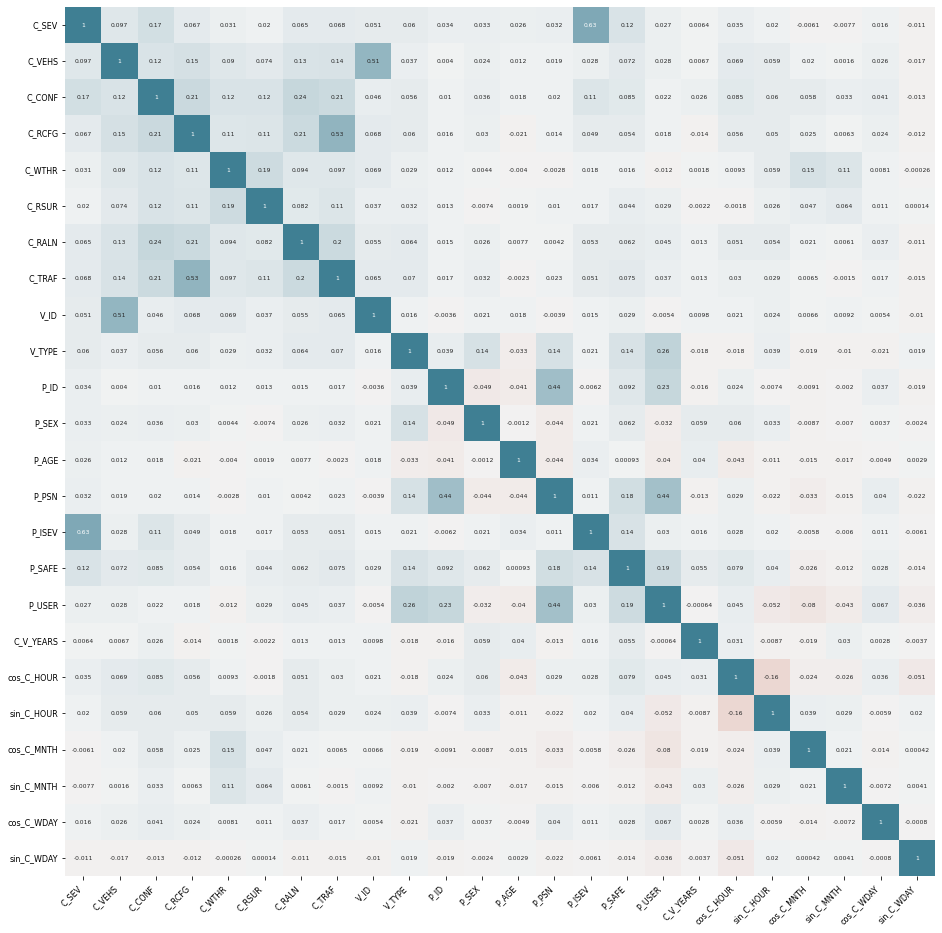

In [90]:
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)



corr_matrix = colisiones_df.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 16))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)

Como vemos, la variable mas correlacionada con la variable objetivo es P_ISEV, algo que es entendible ya que esta variable nos indica el tratamiento medico a posteriori del accidente. La segunda con mayor correlacion es C_CONF que nos indica como ha sido la colision en el accidente, lo cual tambien es entendible que tenga mucha relacion con si hay o no fallecidos en dicho accidente.

# Separación en train y test

Realizamos, una vez hechas las transformaciones, sepación entre train y test, con un porcentaje de test del 30%.

In [91]:
collision_xtrain, collision_xtest, collision_ytrain, collision_ytest = train_test_split(colisiones_df.drop('C_SEV',axis=1),
                                                                                       colisiones_df['C_SEV'],
                                                                                       test_size = 0.3,
                                                                                       random_state= 0)
collision_train = pd.concat([collision_xtrain, collision_ytrain], axis = 1)
collision_test = pd.concat([collision_xtest, collision_ytest], axis = 1)

In [92]:
collision_xtrain.isna().sum()

C_VEHS            0
C_CONF            0
C_RCFG            0
C_WTHR            0
C_RSUR            0
C_RALN            0
C_TRAF            0
V_ID              0
V_TYPE            0
P_ID              0
P_SEX             0
P_AGE             0
P_PSN             0
P_ISEV            0
P_SAFE            0
P_USER            0
C_V_YEARS         0
cos_C_HOUR    26935
sin_C_HOUR    26935
cos_C_MNTH        0
sin_C_MNTH        0
cos_C_WDAY      428
sin_C_WDAY      428
dtype: int64

## Tratamiento de NA's en Train

Puesto que las variables temporales han sido codificadas se opta por rellenar los valores NAs con la moda de los datos. En este caso,puesto que tras la codificación se ha generado un par de datos, se considera que la moda de las nuevas variables que conforman los Senos y Cosenos de las variables primitivas se corresponden con la moda de aquellas.

In [93]:
collision_train['sin_C_WDAY']=collision_train['sin_C_WDAY'].fillna((collision_train['sin_C_WDAY'].mode()[0]))

In [94]:
collision_train['cos_C_WDAY']=collision_train['cos_C_WDAY'].fillna((collision_train['cos_C_WDAY'].mode()[0]))

In [95]:
collision_train['sin_C_WDAY'].unique()

array([-4.33883739e-01,  7.81831482e-01, -9.74927912e-01, -7.81831482e-01,
        4.33883739e-01,  9.74927912e-01, -2.44929360e-16])

In [96]:
collision_train['cos_C_WDAY'].unique()

array([-0.90096887,  0.6234898 , -0.22252093,  0.6234898 , -0.90096887,
       -0.22252093,  1.        ])

In [97]:
collision_train['sin_C_HOUR']= collision_train['sin_C_HOUR'].groupby(collision_train["sin_C_WDAY"]).fillna((collision_train['sin_C_HOUR'].mode()[0]))

In [98]:
collision_train['cos_C_HOUR']= collision_train['cos_C_HOUR'].groupby(collision_train["cos_C_WDAY"]).fillna((collision_train['cos_C_HOUR'].mode()[0]))

In [99]:
collision_train.isna().sum()

C_VEHS        0
C_CONF        0
C_RCFG        0
C_WTHR        0
C_RSUR        0
C_RALN        0
C_TRAF        0
V_ID          0
V_TYPE        0
P_ID          0
P_SEX         0
P_AGE         0
P_PSN         0
P_ISEV        0
P_SAFE        0
P_USER        0
C_V_YEARS     0
cos_C_HOUR    0
sin_C_HOUR    0
cos_C_MNTH    0
sin_C_MNTH    0
cos_C_WDAY    0
sin_C_WDAY    0
C_SEV         0
dtype: int64

# Tratamiento de NA's de TEST

Puesto que las variables temporales han sido codificadas se opta por rellenar los valores NAs con la moda de los datos. En este caso,puesto que tras la codificación se ha generado un par de datos, se considera que la moda de las nuevas variables que conforman los Senos y Cosenos de las variables primitivas se corresponden con la moda de aquellas.

La forma en la que se van a los días de la semana y las horas es agrupando por día de la semana y asignando la moda. Así, por ejemplo, en el caso de las horas, se asignará la moda conforme al día de la semana en el que se sitúe el missing value.

In [100]:
collision_test['sin_C_WDAY']=collision_test['sin_C_WDAY'].fillna((collision_train['sin_C_WDAY'].mode()[0]))

In [101]:
collision_test['cos_C_WDAY']=collision_test['cos_C_WDAY'].fillna((collision_train['cos_C_WDAY'].mode()[0]))

In [102]:
collision_test['cos_C_HOUR']= collision_test['cos_C_HOUR'].groupby(collision_test["cos_C_WDAY"]).fillna((collision_train['cos_C_HOUR'].mode()[0]))

In [103]:
collision_test['sin_C_HOUR']= collision_test['sin_C_HOUR'].groupby(collision_test["sin_C_WDAY"]).fillna((collision_train['sin_C_HOUR'].mode()[0]))

In [104]:
collision_test.isnull().sum()

C_VEHS        0
C_CONF        0
C_RCFG        0
C_WTHR        0
C_RSUR        0
C_RALN        0
C_TRAF        0
V_ID          0
V_TYPE        0
P_ID          0
P_SEX         0
P_AGE         0
P_PSN         0
P_ISEV        0
P_SAFE        0
P_USER        0
C_V_YEARS     0
cos_C_HOUR    0
sin_C_HOUR    0
cos_C_MNTH    0
sin_C_MNTH    0
cos_C_WDAY    0
sin_C_WDAY    0
C_SEV         0
dtype: int64

In [105]:
collision_train.dtypes

C_VEHS        float64
C_CONF        float64
C_RCFG        float64
C_WTHR        float64
C_RSUR        float64
C_RALN        float64
C_TRAF        float64
V_ID          float64
V_TYPE        float64
P_ID          float64
P_SEX         float64
P_AGE         float64
P_PSN         float64
P_ISEV        float64
P_SAFE        float64
P_USER        float64
C_V_YEARS       int64
cos_C_HOUR    float64
sin_C_HOUR    float64
cos_C_MNTH    float64
sin_C_MNTH    float64
cos_C_WDAY    float64
sin_C_WDAY    float64
C_SEV           int64
dtype: object

In [106]:
collision_xtrain= collision_train.drop('C_SEV',axis=1)
collision_ytrain= collision_train['C_SEV']

In [107]:
collision_xtrain.isnull().sum()

C_VEHS        0
C_CONF        0
C_RCFG        0
C_WTHR        0
C_RSUR        0
C_RALN        0
C_TRAF        0
V_ID          0
V_TYPE        0
P_ID          0
P_SEX         0
P_AGE         0
P_PSN         0
P_ISEV        0
P_SAFE        0
P_USER        0
C_V_YEARS     0
cos_C_HOUR    0
sin_C_HOUR    0
cos_C_MNTH    0
sin_C_MNTH    0
cos_C_WDAY    0
sin_C_WDAY    0
dtype: int64

In [108]:
collision_xtest['sin_C_WDAY']=collision_xtest['sin_C_WDAY'].fillna((collision_xtrain['sin_C_WDAY'].mode()[0]))
collision_xtest['cos_C_WDAY']=collision_xtest['cos_C_WDAY'].fillna((collision_xtrain['cos_C_WDAY'].mode()[0]))

In [109]:
collision_xtest['cos_C_HOUR']=collision_xtest['cos_C_HOUR'].fillna((collision_xtrain['cos_C_HOUR'].mode()[0]))
collision_xtest['sin_C_HOUR']=collision_xtest['sin_C_HOUR'].fillna((collision_xtrain['sin_C_HOUR'].mode()[0]))

In [110]:
collision_xtest.isnull().sum()

C_VEHS        0
C_CONF        0
C_RCFG        0
C_WTHR        0
C_RSUR        0
C_RALN        0
C_TRAF        0
V_ID          0
V_TYPE        0
P_ID          0
P_SEX         0
P_AGE         0
P_PSN         0
P_ISEV        0
P_SAFE        0
P_USER        0
C_V_YEARS     0
cos_C_HOUR    0
sin_C_HOUR    0
cos_C_MNTH    0
sin_C_MNTH    0
cos_C_WDAY    0
sin_C_WDAY    0
dtype: int64

In [111]:
collision_xtest.dtypes

C_VEHS        float64
C_CONF        float64
C_RCFG        float64
C_WTHR        float64
C_RSUR        float64
C_RALN        float64
C_TRAF        float64
V_ID          float64
V_TYPE        float64
P_ID          float64
P_SEX         float64
P_AGE         float64
P_PSN         float64
P_ISEV        float64
P_SAFE        float64
P_USER        float64
C_V_YEARS       int64
cos_C_HOUR    float64
sin_C_HOUR    float64
cos_C_MNTH    float64
sin_C_MNTH    float64
cos_C_WDAY    float64
sin_C_WDAY    float64
dtype: object

# Escalado

Antes de llevar a cabo el Oversampling, vamos a realizar el escalado de las variables estandarizando los valores quitandoles la media y escalandolos a la varianza unitaria.

In [112]:
scaler = StandardScaler()
model_scaled = scaler.fit(collision_xtrain)
collision_xtrain_scaled = pd.DataFrame(scaler.transform(collision_xtrain), columns = collision_xtrain.columns, index = collision_xtrain.index)
collision_xtest_scaled = pd.DataFrame(scaler.transform(collision_xtest), columns = collision_xtest.columns, index = collision_xtest.index)

In [113]:
collision_xtrain_scaled.describe()

C_VEHS        C_CONF        C_RCFG        C_WTHR        C_RSUR  \
count  3.026154e+06  3.026154e+06  3.026154e+06  3.026154e+06  3.026154e+06   
mean   6.062476e-15  8.596382e-15  7.140255e-15  1.300561e-14 -6.115655e-15   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -1.343579e+00 -6.031858e-01 -1.368780e+00 -1.668789e+00 -4.783038e+00   
25%   -2.940243e-01 -6.031858e-01 -8.110543e-01 -2.270251e-01  5.395066e-02   
50%   -2.334015e-01 -1.847920e-01 -8.110543e-01 -2.270251e-01  5.395066e-02   
75%   -2.334015e-01  3.193865e-02  1.265518e+00 -2.270251e-01  5.395066e-02   
max    8.161455e+01  4.656671e+00  1.146418e+01  6.213471e+00  1.681242e+01   

             C_RALN        C_TRAF          V_ID        V_TYPE          P_ID  \
count  3.026154e+06  3.026154e+06  3.026154e+06  3.026154e+06  3.026154e+06   
mean  -1.181702e-14  3.032475e-14 -6.592144e-15 -1.776055e-14  7.874066e-15   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -1.216131e+00 -1.877200e+00 -2.423259e+00 -1.765581e+00 -3.760163e+00   
25%   -3.437770e-01 -1.355311e+00 -4.920392e-01 -2.492231e-01 -3.067211e-01   
50%   -3.437770e-01  8.368487e-01  2.396688e-01 -2.492231e-01 -3.067211e-01   
75%   -3.437770e-01  8.368487e-01  4.138277e-01 -2.492231e-01  6.804221e-02   
max    2.888749e+00  9.306336e+00  1.129541e+02  7.374053e+00  3.603382e+01   

       ...        P_ISEV        P_SAFE        P_USER     C_V_YEARS  \
count  ...  3.026154e+06  3.026154e+06  3.026154e+06  3.026154e+06   
mean   ...  8.560165e-15 -1.598853e-14 -7.899596e-15  5.342755e-17   
std    ...  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min    ... -1.084735e-01 -1.054184e+00 -3.197916e+00 -1.734686e+00   
25%    ... -1.084735e-01 -2.339293e-01 -5.524119e-01 -8.183667e-01   
50%    ... -5.928547e-02 -2.339293e-01 -5.524119e-01 -8.531155e-02   
75%    ... -5.928547e-02 -2.339293e-01  7.393123e-01  6.477436e-01   
max    ...  1.244185e+01  5.063296e+00  5.809467e+00  1.750801e+01   

         cos_C_HOUR    sin_C_HOUR    cos_C_MNTH    sin_C_MNTH    cos_C_WDAY  \
count  3.026154e+06  3.026154e+06  3.026154e+06  3.026154e+06  3.026154e+06   
mean   6.475179e-16  1.548223e-15 -6.025460e-17  3.111087e-15 -2.311488e-15   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -1.166375e+00 -1.048780e+00 -1.404511e+00 -1.369174e+00 -1.262222e+00   
25%   -8.322656e-01 -8.822137e-01 -1.218079e+00 -1.175988e+00 -1.262222e+00   
50%   -1.471326e-01 -3.234174e-01 -1.296522e-02  7.278642e-02 -2.821237e-01   
75%    6.895393e-01  6.715044e-01  1.192148e+00  7.937667e-01  9.400383e-01   
max    1.927514e+00  1.978598e+00  1.378580e+00  1.514747e+00  1.483952e+00   

         sin_C_WDAY  
count  3.026154e+06  
mean   3.155604e-15  
std    1.000000e+00  
min   -1.286789e+00  
25%   -1.018411e+00  
50%    6.822738e-02  
75%    1.154866e+00  
max    1.423243e+00  

[8 rows x 23 columns]

Tras el escalado, eliminamos 3 variables que no queremos para introducir en los modelos. 

Por un lado están P_ID y V_ID que son variables identificatorias tanto de vehiculos(V_ID) como de personas(P_ID) por lo que no tienen un valor explicativo de la variable objetivo.

Por otro lado tenemos P_ISEV que es el tratamiento medico requerido tras el accidente, algo que, al ser a posteriori, no nos ofrece un valor explicativo de la variable objetivo. Aun así sabemos que tendrá una alta correlacion con la variable target ya que, a mayor gravedad del accidente, mayor tratamiento medico requerira el paciente.

In [114]:
collision_xtrain_scaled= collision_xtrain_scaled.drop('P_ISEV',axis=1)
collision_xtest_scaled= collision_xtest_scaled.drop('P_ISEV',axis=1)

In [115]:
collision_xtrain_scaled= collision_xtrain_scaled.drop('P_ID',axis=1)
collision_xtest_scaled= collision_xtest_scaled.drop('P_ID',axis=1)

In [116]:
collision_xtrain_scaled= collision_xtrain_scaled.drop('V_ID',axis=1)
collision_xtest_scaled= collision_xtest_scaled.drop('V_ID',axis=1)

# Oversampling

El desbalanceo de datos que se ha puesto de manifiesto anteriormente y que podría generar problemas en la generación al entrenar la máquina se corrige mediante estrategia de oversampling. En este caso la estrategia que se ha seguido es con el algoritmo SMOTE que utiliza un enfoque de sobremuestreo en el que la clase minoritaria es sobremuestreada creando ejemplos sintéticos en lugar de sobremuestrear con sustituciones

In [117]:
print("Before oversampling: ",Counter(collision_ytrain))

Before oversampling:  Counter({0: 2977151, 1: 49003})


In [118]:
SMOTE = SMOTE(random_state=0, sampling_strategy=0.3)

In [119]:
collision_xtrain_SMOTE, collision_ytrain_SMOTE  = SMOTE.fit_resample(collision_xtrain_scaled,collision_ytrain)

In [120]:
print("After oversampling: ",Counter(collision_ytrain_SMOTE))

After oversampling:  Counter({0: 2977151, 1: 893145})


In [121]:
collision_xtrain_SMOTE['C_CONF']

0          0.784962
1         -0.603186
2         -0.603186
3         -0.105249
4         -0.460533
             ...   
3870291    4.656671
3870292   -0.603186
3870293    4.656671
3870294    0.567837
3870295    0.710292
Name: C_CONF, Length: 3870296, dtype: float64

# Guardamos los datos

In [ ]:
collision_xtrain_SMOTE.to_csv('../data/collision_xtrain_SMOTED.csv',header=True, index=False)

In [ ]:
collision_ytrain_SMOTE.to_csv('../data/collision_ytrain_SMOTED.csv',header=True, index=False)

In [ ]:
collision_xtest_scaled.to_csv('../data/collision_xtest_SMOTED.csv',header=True, index=False)

In [ ]:
collision_ytest.to_csv('../data/collision_ytest_SMOTED.csv',header=True, index=False)